# Notebook to investigate neutrino tridents and dimuon production

In [1]:
from Code import *
import numpy as np
import uproot
from scipy.special import gamma
from numpy import linalg
from copy import copy, deepcopy
from multiprocessing import Process, Pool, cpu_count
from functools import partial
import sys
from scipy import interpolate
from scipy.optimize import leastsq as lsq
from scipy.interpolate import LinearNDInterpolator

## Quick flags for enabling/disabling features consuming time and memory

In [2]:
useAcc = True           #Include experimental acceptance factors in spectra weights where available?
FourFermi = True        #Compute 4-fermion verted EFT processes?
writeJSON = True        #Necessary to (re)write JSON files?
non_mumu_FS = False     #Include trident processes with non-mu charged leptons in the FS?
store_evtlines = False  #Store all the lines in the MC event file to mcbins object?

#Suitable selection for No-acc (no experimental acceptance) plots instead
#useAcc = False          #Include experimental acceptance factors in spectra weights where available?
#FourFermi = False       #Compute 4-fermion verted EFT processes?
#writeJSON = True        #Necessary to (re)write JSON files?
#non_mumu_FS = True      #Include trident processes with non-mu charged leptons in the FS?
#store_evtlines = False  #Store all the lines in the MC event file to mcbins object?

## Define global quantities: predictions & detectors to load etc.

In [3]:
#Define different flux components. N.B. these are neutrino parents on the production side, 
#NOT parents of the muons on detection side
origins = {"pion": [211,-211], "kaon": [321,-321,310,130], "charm": [411,421,431,4122,-411,-421,-431,-4122]}
plabels = ['\pi','K','c']
basicp=[x for x in origins][0]
vpids = {12:[],-12:[],14:[],-14:[],16:[],-16:[]}
vpidstrs=[str(vpidkey) for vpidkey in list(vpids.keys())]

Nptypes = len(list(origins.keys()))

#detectors = ['FASERv2','FLARE','NuTeV@FPF-Fe','NuTeV@FPF-Pb']
detectors = ['FASERv2']

#Define the generators to be investigated
gens = [['SIBYLL', 'SIBYLL'],\
        ['QGSJET', 'BDGJKR'],\
        ['EPOSLHC','BKSS'],\
        ['EPOSLHC','BKRS']]
genprefixes = [['VLarge_','VLarge_'],\
               ['VLarge_','VLarge_'],\
               ['VLarge_','VLarge_'],\
               ['VLarge_','VLarge_']]
if len(gens)!=len(genprefixes):
    raise SystemExit('ERROR: each prediction must be given a filename prefix')
#Gen.s in 1st col above are for light contributions, 2nd col for charm
genpars=['light', 'charm']

genpairBL = {'light':'EPOSLHC','charm':'BKRS'}
genpairBLstr = '&'.join(list(genpairBL.values()))

#List of unique detector materials
detmats = []
for detector in detectors:
    detmat = experiments[detector]['material']
    if detmat not in detmats: detmats.append(detmat)            


#Ensure proper formatting of input gens table
if np.array(gens[0]).ndim==0:
    gens = np.array([[g] for g in gens])
else:
    gens = np.array(gens)

#Numbers of independent generators in different "sectors", e.g. 0=light and 1=charm 
Ng = len(gens)  #Number of all generator (pairs)
Ngi=[]          #Number of indep. gen. per particle type
Nginames=[]     #Names of the gen. corresponding to^, helps in lambdamatrix interpretation
for isec in range(len(gens[0])):
    indeps=[]
    for g in gens[:,isec]:
        if g not in indeps:
            indeps.append(g)
    Ngi.append(len(indeps))
    Nginames.append(indeps)

#Assign numbers of gens to be used for different particle type
icharm = genpars.index('charm') if 'charm' in genpars else 0
ilight = genpars.index('light') if 'light' in genpars else 0
Ngp=[Ngi[icharm if 'charm' in p else ilight] for p in list(origins.keys())]  #Num. of gen per particle type
Ngpnames=[Nginames[icharm if 'charm' in p else ilight] for p in list(origins.keys())]
gptypes=['charm' if 'charm' in p else 'light' for p in list(origins.keys())]

#AUX function to construct a matrix of lambdavalues to single out a given pair of predictions.
#If a generator is not found for that particle type, return average
#Param.
#  genpairs    dictionary specifying prediction for particle type, e.g. {'light':'EPOSLHC', 'charm':'SIBYLL'}
def genPairLambdaMatrix(genpairs):
    ret = []
    for i,Ngpnamesub in enumerate(Ngpnames):
        genname=genpairs[gptypes[i]]
        if genname in Ngpnamesub:
            tmp=np.array([int(genname==name) for name in Ngpnamesub][1:])
            if sum(tmp)==0: tmp = np.multiply(-1,np.ones(len(tmp)))
        else:
            print('Generator ',genname,' not found for ' + gptypes[i] + ' particles, returning avg. params')
            tmp = np.zeros(len(Ngpnamesub)-1)
        ret.append(tmp)
    return ret


#Default values for all lambdas -- redefining the "zero" here allows studying e.g. single-generator-centered models
lambdazeros = [np.zeros(n-1) for n in Ngp]  #All-zero lambdas
fszero = 0.0  #Likewise, possible to set enhanced strangeness parameter f_s baseline to a non-zero value

#Tags indicating the name of the code producing various plots etc
codename=''
for ig in range(len(genpars))[::-1]:
    codename += '_l' if genpars[ig]=='light' else 'c'
    for g in gens[:,ig]:
        g = g.split('_')[0]
        gentag=g[0]
        if 'ANNA' in g:
            gentag='A'
        elif 'YUSEON' in g:
            gentag='Y'
        elif 'RAFAL' in g:
            gentag='R'
        codename += gentag
if useAcc: codename+='_acc'
fitspectratag='fitspectra/'+codename+'_'

#For tridents_XY specifies final state charged lepton flavors; if none are given, mumu assumed
allprocs = ['dimuons','tridents']
if non_mumu_FS:
    allprocs += ['tridents_ee','tridents_emu','tridents_etau','tridents_mutau','tridents_tautau']
if FourFermi:
    allprocs += ['4F']

## Muon energy efficiency factor for scaling FASER$\nu$2 neutrino spectra

Finding efficiency interpolation function for  dimuons
Finding efficiency interpolation function for  tridents


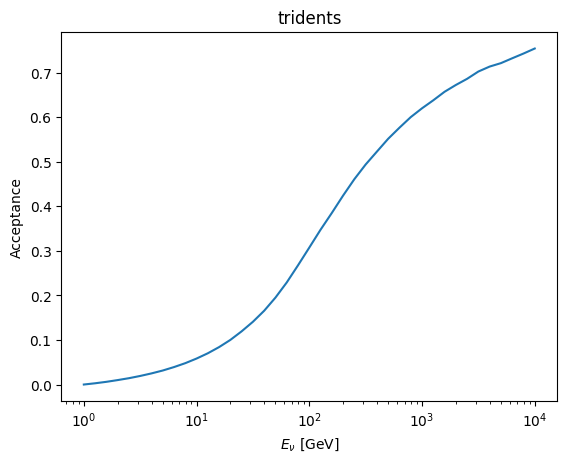

In [4]:
#The 'withPb' case also contains a Pb layer decreasing the overall factor a bit, 
#but we have to assume W for the rest of the calculation.
#The other case corresponds to a plain block of W.
acctable='files/efficiency/FASERnu2_efficiency_withPb_100percentmuonenergyloss.txt'
#acctable='files/efficiency/FASERnu2_efficiency_100percentmuonenergyloss.txt'  #No lead layer effect

#Find factors that are to be applied for weighing the spectra when producing JSONs
#It has been verified that the efficiency factors are practically identical for all nuids, so use only nu_mu case.
#Moreover, we use the SM trident factor also for the BSM cases.
accEmuFASERv2={}
if useAcc:
    accEmuFASERv2['dimuons']  = efficiency(proc='dimuons', acctable=acctable,detector='FASERv2')
    accEmuFASERv2['tridents'] = efficiency(proc='tridents',acctable=acctable,detector='FASERv2',nuid='14')
#efficiency(proc='tridents',acctable=acctable,detector='FASERv2',nuid='12')
#efficiency(proc='tridents',acctable=acctable,detector='FASERv2',nuid='-12')
#efficiency(proc='tridents',acctable=acctable,detector='FASERv2',nuid='-14')

## Fetch neutrino spectra

In [5]:
def get_binned_spectra(inputs, outputfile, experiment, ebins, rbins):
    
    #Init dictionaries 
    samples={}
    for vpid in vpids:
        samples[vpid]={}
        for proc in allprocs:
            samples[vpid][proc]={}
            for origin in origins: samples[vpid][proc][origin]=[]

    #Detector properties
    xmin = experiments[experiment]["xmin"]
    ymin = experiments[experiment]["ymin"]
    xmax = experiments[experiment]["xmax"]
    ymax = experiments[experiment]["ymax"]
    posz = experiments[experiment]["posz"]
    lumi = experiments[experiment]["lumi"]
    
    #Loop files & events
    for filename in inputs:
        events = readfile_txt(filename)
        for event in events:
            vpid, hpid, x0, y0, z0, thx, thy, en, w0 = event
            vpid, hpid = int(vpid), int(hpid)            
            x = x0 + thx*(posz-480)
            y = y0 + thy*(posz-480)
            r = np.sqrt(x**2+y**2)
            if x<xmin or x>xmax: continue
            if y<ymin or y>ymax: continue
            for proc in allprocs:
                acc = 1.0  #Acceptance related factors to reduce statistics
                if useAcc and experiment=='FASERv2':
                    accproc = 'tridents'
                    if 'dimuons' in proc: accproc = 'dimuons'
                    acc *= accEmuFASERv2[accproc](en)
                w = w0*acc
                prob=0  #Init interaction probability
                #Test cross section previously used for comparisons, computed only for nu_mu
                if 'WfromAr' in experiment and vpid!=14: continue
                #Check for neutrino ID and FS charged lepton configurations not present in the SM
                if (proc=='tridents_mutau') and abs(vpid)==12: continue
                if (proc=='tridents_etau')  and abs(vpid)==14: continue
                if (proc=='tridents_emu')   and abs(vpid)==16: continue
                #Only numu (& no nubarmu) bg available, assume nubar equal to nu (effectively is after cuts)
                if proc=='dimuons':
                    if abs(vpid)!=14: continue  #No nutau or nuel initiated bg available
                    prob = get_interaction_probability(experiment,en,str(abs(vpid)),proc)
                #Also the g',m_Z' grid is only computed for neutrinos (not anti-) since the xsec agree
                elif 'MZP' in proc:
                    prob = get_interaction_probability(experiment,en,str(abs(vpid)),proc,gpfix)
                elif '4F' in proc and abs(vpid)!=14:
                    prob = 0.0  #Consider only nu_mu nu_mu mu mu vertices for the 4-fermion EFT contribution
                else:
                    prob = get_interaction_probability(experiment,en,str(vpid),proc)
                for origin in origins:
                    if hpid in origins[origin]: samples[vpid][proc][origin].append([en,r,w, w*prob])
   
    #Extract & save w/ pandas
    data = {}
    for vpid in vpids:
        data[vpid]={}
        for origin in origins:
            data[vpid][origin] = {}
            
            #get histograms
            rate={}
            for proc in allprocs:
                sample = np.array(samples[vpid][proc][origin])
                if len(sample)==0: 
                    flux=np.array([[0 for _ in rbins[:-1]] for _ in ebins[:-1]])
                    rate[proc]=np.array([[0 for _ in rbins[:-1]] for _ in ebins[:-1]])
                else: 
                    flux, _, _ = np.histogram2d(sample.T[0], sample.T[1], weights=sample.T[2], bins=[ebins,rbins])
                    rate[proc], _, _ = np.histogram2d(sample.T[0], sample.T[1],\
                                                      weights=sample.T[3], bins=[ebins,rbins])
                
            # write to data
            data[vpid][origin]['ebins']=ebins.tolist() 
            data[vpid][origin]['rbins']=rbins.tolist() 
            data[vpid][origin]['n_nu' ]=(lumi*1000*flux).tolist()
            for proc in allprocs:
                data[vpid][origin]['n_int_'+proc]=(lumi*1000*rate[proc]).tolist()
            
    # convert to data frame and save
    save_json(fitspectratag+outputfile,data)

In [6]:
#A handle to get all radN cases for one generator(pair), for multiprocessing
def get_binned_spectra_handle(ipairs):
    global gens
    global genprefixes
    processed=0
    for ipair in ipairs:
        igen,idet = ipair
        gen = gens[igen]
        genprefix = genprefixes[igen]
        fluxfiles = ['files/'+genprefix[i]+gen[i]+'_'+genpars[i]+'_0.txt' for i in range(len(gen))]    
        detector=detectors[idet]
        #ebins = np.logspace(1,4,61)  #20 bins per decade
        #ebins = np.logspace(1,4,31)  #10 bins per decade
        ebins = np.logspace(0,4,21)   #5 bins per decade DEFAULT
        #ebins = np.logspace(0,4,5)   #1 bin per decade
        #ebins = np.logspace(0,4,2)   #1 bin
        #FLArE radial bins (default)
        rbins1 = np.array([0,2])
        rbins3 = np.array([0, 0.1, 0.25, 2])
        if   detector=='FASERv2': #.2
            rbins1 = np.array([0,0.3])
            rbins3 = np.array([0,0.1,0.2,0.3])
        elif detector=='FASERv':  #.125
            rbins1 = np.array([0,0.2])
            rbins3 = np.array([0,0.06,0.13,0.2])
        get_binned_spectra(
            outputfile = '_'.join(gen)+'_'+detector+'_rad1',
            inputs = fluxfiles,
            experiment=detector,
            ebins=ebins,
            rbins=rbins1
        )
        processed += 1
        progstr = str(processed)+'/'+str(len(ipairs))
        print('A get_binned_spectra process has written '+progstr+' JSONs',ipair)

In [7]:
#Fetch spectra for different generators and radial bin cases via the above handle
if writeJSON:
    #Construct array of generator pair and detector indices for the processes
    procind = range(len(gens))
    procind = [[i,j] for j in range(len(detectors)) for i in procind]
    print('Total of '+str(len(procind))+' index pairs to consider:',procind)
    
    Nmax = 8  #Divide into max this many blocks, "number of CPUs"
    step = int(np.ceil(len(procind)/Nmax))
    procind_divided = [procind[n*step:(n+1)*step] for n in range(Nmax)]
    
    #Check for possibility that all available processes weren't assigned jobs
    N = min(sum([len(pd)!=0 for pd in procind_divided]),Nmax)
    procind_final = procind_divided[:N]
    print('With Nmax = '+str(Nmax)+', optimal to consider '+str(N)+' index pairs:')
    for pd in procind_final: print(pd)
    readprocs = Pool(processes=N)
    readprocs.map(get_binned_spectra_handle, procind_final)

Total of 4 index pairs to consider: [[0, 0], [1, 0], [2, 0], [3, 0]]
With Nmax = 8, optimal to consider 4 index pairs:
[[0, 0]]
[[1, 0]]
[[2, 0]]
[[3, 0]]
A get_binned_spectra process has written 1/1 JSONs [0, 0]
A get_binned_spectra process has written 1/1 JSONs [1, 0]
A get_binned_spectra process has written 1/1 JSONs [2, 0]
A get_binned_spectra process has written 1/1 JSONs [3, 0]


In [8]:
xsec4F={}  #Init global dictionary to contain interpolators
if FourFermi:
    for mat in detmats:
        for nuid in ['14','-14']:
            matnu = mat + '_' + nuid
            #The grids of delta g_V and delta g_A values based on which to interpolate
            dGVvals = ['-5.00', '-4.75', '-4.50', '-4.25', '-4.00',\
                       '-3.75', '-3.50', '-3.25', '-3.00', '-2.75',\
                       '-2.50', '-2.25', '-2.00', '-1.75', '-1.50',\
                       '-1.25', '-1.00', '-0.75', '-0.50', '-0.25',\
                        '0.00',  '0.25',  '0.50',  '0.75',  '1.00']
            dGAvals = ['-2.00', '-1.75', '-1.50', '-1.25', '-1.00',\
                       '-0.75', '-0.50', '-0.25',  '0.00',  '0.25',\
                        '0.50',  '0.75',  '1.00',  '1.25',  '1.50',\
                        '1.75',  '2.00',  '2.25',  '2.50',  '2.75',\
                        '3.00',  '3.25',  '3.50',  '3.75',  '4.00']
            Etmp = np.loadtxt('files/trident_mc/tridents/xsec/cm2_nucleon/4F_dGV-0_dGA-0_Pb_14.txt',usecols=0) #All E agree
            xsec=[]
            #N.B. the outer loop is dGA, inner dGV, but at (*) meshgrid outputs dGV to the left of dGA
            #     The innermost Etmp is however the rightmost in (*).
            #     This was checked w/ print() st. the interpolator reproduced the computed xsec files
            for dGA in dGAvals:
                xsecdGV=[]
                for dGV in dGVvals:
                    dGVd = dGV.replace('.','d')
                    dGAd = dGA.replace('.','d')
                    while len(dGVd)>1 and (dGVd[-1]=='0' or dGVd[-1]=='d'): dGVd = dGVd[:-1]  #Remove trailing zeros
                    while len(dGAd)>1 and (dGAd[-1]=='0' or dGAd[-1]=='d'): dGAd = dGAd[:-1]
                    xsectmp = np.loadtxt('files/trident_mc/tridents/xsec/cm2_nucleon/4F_dGV-'+dGVd+'_dGA-'+dGAd+'_'+matnu+'.txt',\
                                         usecols=1)
                    xsecdGV.append(xsectmp)
                xsec.append(xsecdGV)
            xsec=np.array(xsec)        
            #(*) N.B. the innermost loop above is the leftmost variable here, but the E (not looped over) is rightmost
            dGVg,dGAg,Eg = np.meshgrid([float(d) for d in dGVvals],[float(d) for d in dGAvals],Etmp)
            #Store result to the global dictionary
            xsec4F[matnu] = LinearNDInterpolator(list(zip(dGVg.flatten(),dGAg.flatten(),Eg.flatten())),xsec.flatten())

###Printouts used when checking (*)
#if FourFermi:
#    for dv in dGVvals:
#        for da in dGAvals:
#            for E in Etmp:
#                print(float(dv),float(da),interp([float(dv),float(da),E]))

In [9]:
#Return a scaling factor for 4F n_int based on the ratio of SM vs 4F xsec per E-bin
def ratio4FSM(dGV,dGA,ebins,mat,nuid):
    ret=[]
    ebinsarr = np.array(ebins)  #Ensure ebins format
    ecenters = (ebinsarr[1:]+ebinsarr[:-1])/2
    if str(nuid) not in ['14','-14']:
        print('WARNING: ratio4FSM called for nuid='+str(nuid)+' but only nu_mu can be constrained. Skipping.')
        return [1.0 for _ in range(len(ecenters))]
    matnu=mat+'_'+str(nuid)
    ret=[1.0 if xsec4F[matnu]([0,0,E])==0 else xsec4F[matnu]([dGV,dGA,E])/xsec4F[matnu]([0,0,E]) for E in ecenters]
    return np.array(ret)

### Define the model computation for obtaining spectra

In [10]:
#The model expression
def modelExpr(lambdas,dataG,vpid,n2calc,orig,iorig):
    return (   (1.-sum(lambdas[orig]))\
               *np.array(dataG[0][vpid][orig][n2calc])\
             + sum( [ (1.+Ngp[iorig]*lam-sum(lambdas[orig]))\
                     *np.array(dataG[il+1][vpid][orig][n2calc])\
                     for il,lam in enumerate(lambdas[orig])])\
            ) / Ngp[iorig]
#Param:
#  detector   E.g. 'FASERv2'
#  radN       E.g. '_rad1'
#  lambdamat  Matrix of values for the lambda parameters amounting to differences between predictions
#  fstat      Increase/decrease overall statistics by a global constant factor
#  modelpars  A dictionary of other parameters than lambda. These can be e.g.
#      fs     Enhanced strangeness parameter for converting fractions of pions/kaons into one another 
def model(detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,modelpars={}):
    
    global basicp
    
    #Init/parse non-lambda/non-fstat parameters
    fsgiven  = 'fs'  in list(modelpars.keys())
    dGVgiven = 'dGV' in list(modelpars.keys())
    dGAgiven = 'dGA' in list(modelpars.keys())
    fs  = 0.0 if not fsgiven  else modelpars['fs']
    dGV = 0.0 if not dGVgiven else modelpars['dGV']
    dGA = 0.0 if not dGAgiven else modelpars['dGA']
    
    #Load data
    dataG = []
    for gen in gens:
        jsontag = fitspectratag+'_'.join(gen)+'_'+detector+radN
        dataG.append(load_json(jsontag))
      
    #Ensure no dimension mismatch
    for i,lvec in enumerate(lambdamat):
        if len(lvec)!=(Ngp[i]-1):
            print("ERROR #lambdas for particle type="+str(len(lvec))+" =/= #generators-1="+str(Ngp[i]-1))
            sys.exit()
    
    #Fetch bin limits
    ebins = dataG[0][vpidstrs[0]][basicp]['ebins']
    rbins = dataG[0][vpidstrs[0]][basicp]['rbins']
    
    #Dictionary of flux components
    lambdas={}
    for iorig,orig in enumerate(list(origins.keys())):
        lambdas[orig] = deepcopy(lambdamat[iorig])

    #Compute number of events using model expression
    n_nu = {}
    n_int = {}
    for vpidint in list(vpids.keys()):
        vpid=str(vpidint)
        #Numbers per neutrino flavor and origin
        n_nu[vpid] = {}
        n_int[vpid] = {}
        for iorig,orig in enumerate(list(origins.keys())):
            n_nu[vpid][orig]  = modelExpr(lambdas,dataG,vpid,'n_nu',orig,iorig) 
            n_int[vpid][orig] = {}
            #Init all procs's n_int histos to baseline values of that parameter
            for proc in allprocs:
                n_int[vpid][orig][proc] = modelExpr(lambdas,dataG,vpid,'n_int_'+proc,orig,iorig)
            #Additional procs for trident cases, SM and BSM
            for proc in [p for p in allprocs if 'dimuons' not in p and 'tridents' not in p]:  #TODO LmuLtau only?
                SMproc = 'tridents'
                fscltag = ''  #Tag for final state charged leptons
                fscls=[]
                if non_mumu_FS: fscls=['_ee','_emu','_etau','_mutau','_tautau']
                for fscl in fscls:
                    if fscl in proc: fscltag = fscl
                #4-Fermi: baseline is dGV=dGA=0 i.e. SM equiv., translate to given dGV,dGA via 4F/SM xsec ratio
                detmat = experiments[detector]['material']
                if FourFermi and '4F' in proc and vpid in ['14','-14'] and (dGAgiven or dGVgiven):
                    BSMfactorvec = ratio4FSM(dGV=dGV,dGA=dGA,ebins=ebins,mat=detmat,nuid=vpid)                    
                    n_int[vpid][orig][proc] = np.multiply(n_int[vpid][orig][proc], BSMfactorvec)

    #Factors for reweighting the numbers of pions and kaons
    if fsgiven:
        scalefs={}
        #Approx 6.6 x more pions than kaons (pheno factor fitted by F. Kling)
        scalefs["kaon"]  = (1.0 + (fs+fszero)*6.6)
        scalefs["pion"]  = (1.0 - (fs+fszero))
        scalefs["charm"] = 1.0              
        for vpidint in list(vpids.keys()):
            vpid=str(vpidint)
            for orig in list(origins.keys()):
                n_nu[vpid][orig] = np.multiply(scalefs[orig], n_nu[vpid][orig]) 
                for proc in allprocs:
                    n_int[vpid][orig][proc] = np.multiply(scalefs[orig],n_int[vpid][orig][proc])
                
    #Sum up different origins' contributions
    data = {}
    for vpidint in list(vpids.keys()):
        vpid=str(vpidint)
        data[vpid]={}
        #Store energy and radial bin info to data object
        data[vpid]['ebins'] = ebins
        data[vpid]['rbins'] = rbins
        #Form basis of spectra for data objects by summing over neutrino parent hadrons
        data[vpid]['n_nu'] = sum(list(n_nu[vpid].values()))
        for proc in allprocs:
            data[vpid]['n_int_'+proc] = sum([n_int[vpid][orig][proc] for orig in list(origins.keys())])

    #Apply factors to <in/de>crease statistics if requested
    for vpidint in list(vpids.keys()):
        vpid=str(vpidint)
        data[vpid]['n_nu'] = np.multiply(fstat,data[vpid]['n_nu'])
        for proc in allprocs:
            data[vpid]['n_int_'+proc] = np.multiply(fstat,data[vpid]['n_int_'+proc])        

    return data

### Sum several detectors into a single model object

In [11]:
#A function for combining multiple experiments into a single model object
#Param
#  detectorlist  list of names of the detectors to combine
#  radNstr       e.g. '_rad1'
#  genpair       the prediction pair to compute the spectra with
#  fstatlist     a list of fstat values to be used for each detector
#  modelpars     a dictionary of non-lambda parameters and their values to use
def detectorSum(detectorlist,radNstr,genpair,fstatlist,modelpars):

    global vpidstrs
    
    #Individual Model objects for considered detectors
    models=[]
    for i,det in enumerate(detectorlist):
        models.append(model(detector=det,radN=radNstr,lambdamat=genPairLambdaMatrix(genpair),\
                            fstat=fstatlist[i],modelpars=modelpars))
    
    #Check bin agreement. For now, demand same bins although there might be ways to avoid this
    binerr = False
    for mod in models:
        for vpid in vpidstrs:
            if models[0][vpid]['ebins']!=mod[vpid]['ebins']:
                print('ERROR in detectorSum: ebins do not agree')
                return {}
            if radNstr[-1]!='1' and models[0][vpid]['rbins']!=mod[vpid]['rbins']:
                print('ERROR in detectorSum: rbins do not agree')
                return {}
    
    #Init return object: assign
    # - all nu ids supported in the whole notebook, 
    # - the same ebins all obj.s have, 
    # - the rbins identical for all objs if considered (i.e. radNstr!='_rad1') or max envelope of all bin limits
    ret={}
    for vpid in vpidstrs:
        ret[vpid]={}
        ret[vpid]['ebins']=models[0][vpid]['ebins']
        if radNstr=='_rad1': 
            ret[vpid]['rbins']=[min([mod[vpid]['rbins'][ 0] for mod in models]),\
                                max([mod[vpid]['rbins'][-1] for mod in models])]
        else: ret[vpid]['rbins']=models[0][vpid]['rbins']
        #The incoming nu spectra are the same for all detectors, 
        #i.e. approximate loss of n_nu in previous detector's interactions negligible wrt huge incoming flux
        ret[vpid]['n_nu'] = models[0][vpid]['n_nu']
        for mod in models:
            for nintkey in [key for key in list(mod[vpid].keys()) if 'n_int' in key]:
                if nintkey not in list(ret[vpid].keys()): ret[vpid][nintkey]=mod[vpid][nintkey]
                else:         ret[vpid][nintkey] = np.add(ret[vpid][nintkey],mod[vpid][nintkey])
    return ret

### Fit data

Let us denote the number of events observed in each bin as $n_i$. These are the observables in our binned histogram analysis. The likelihood function is then a product of the poisson likelihoods for all bins,

\begin{equation}
  L(\text{data}|\text{model})
  = \prod_{\text{bins}~i} \text{Pois}(n_i|N_i)
  = \prod_{\text{bins}~i} \frac{n_i^{N_i} e^{n_i}}{N_i!}
\end{equation}

where $N_i$ is the expected number of events per bin in the model. In the following we provide a function for the expected log-likelihood ratio $\log r$, where the likelihood ratio with respect to the is

\begin{equation}
   r(\lambda^\pi,\lambda^K,\lambda^c) = \frac{ L(\text{expected data}|\lambda^\pi,\lambda^K,\lambda^c)}{ L(\text{expected data}|\lambda^\pi=0,\lambda^K=0,\lambda^c=0)}
\end{equation}

where the expected data corresponds to $\lambda^\pi=\lambda^K=\lambda^c=0$ for generator comparisons. 

In [12]:
def get_llr(detector,proc,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,modelpars={}):
    
    global lambdazeros
    
    modeldata    = model(detector=detector,radN=radN,lambdamat=deepcopy(lambdamat),fstat=fstat,modelpars=modelpars)
    #Cuts and stat factors are not fit parameters, they affect also the expected baseline
    expecteddata = model(detector=detector,radN=radN,lambdamat=deepcopy(lambdazeros),fstat=fstat,modelpars={})

    llr = 0
    for vpid in expecteddata:
        nexpected = expecteddata[vpid]['n_int_'+proc].flatten()
        nmodel    =    modeldata[vpid]['n_int_'+proc].flatten()
        for k, mu in zip(nexpected,nmodel):
            #Log of probability mass function via scipy, log(r) = L - L(lambdas=0)
            kint=max(round(k),0)
            kreal=max(k,0.0)
            mureal=max(mu,0.0)
            llrcontrib={}
            llrcontrib['num'] = 0.0 if mu<0 else poisson.logpmf(mu=mureal,k=kint)
            llrcontrib['den'] = poisson.logpmf(mu=kreal,k=kint)
            #Check for errors in numerator or denominator
            pardict={'mu':mu,'k':k,'mureal':mureal,'kint':kint,'round(k)':round(k),'kreal':kreal}
            for key in list(modelpars.keys()): pardict[key] = modelpars[key]
            for key in list(llrcontrib.keys()):
                if   np.isnan(llrcontrib[key]): llrERROR(key,'nan',pardict=pardict)  #Terminate 
                elif np.isinf(llrcontrib[key]): llrERROR(key,'inf',pardict=pardict)  #Terminate
            llr+= llrcontrib['num'] - llrcontrib['den']
    return llr

Approximate the expected likelihood ratio as

\begin{equation}
  -2\log r = - \frac{d^2 \log r}{d\lambda^{(i)} d\lambda^{(j)}} \Delta \lambda^{(i)} \Delta \lambda^{(j)}
           = I_{ij} \Delta \lambda^{(i)} \Delta \lambda^{(j)}
\end{equation}

where $i,j = \pi, K, c$. In the following, we calculate the so called Fisher Information $I_{ij}$, essentially by finding the Hessian. First, define auxiliary functions for computing the Hessian:

In [13]:
#Compute the [ix,jx] element of the Hessian about the point "lambdazeros" in parameter space
#Param
#  ix,jx          Indices corresponding to the Hessian matrix element to be returned
#  ndim           The number of dimensions
#  detector       The name of the detector to consider
#  radN           Amount of radial bins
#  fstat          Scale statistics by this factor
#  usedmodelpars  List of strings containing the names of non-lambda and non-fstat parameters to be used
def HessianElement(ix,jx,ndim,detector,proc,radN,fstat,usedmodelpars):

    global lambdazeros
    
    dx=0.01

    ipjp = np.zeros(ndim)
    ipjp[ix] += dx
    ipjp[jx] += dx
    ipjm = np.zeros(ndim)
    ipjm[ix] += dx
    ipjm[jx] -= dx
    imjp = np.zeros(ndim)
    imjp[ix] -= dx
    imjp[jx] += dx
    imjm = np.zeros(ndim)
    imjm[ix] -= dx
    imjm[jx] -= dx
    
    llrs=[]

    modelpars={}
    for pars in ipjp,ipjm,imjp,imjm:

        #For constraint studies, pars is appended with additional parameters. Extract them and resize pars
        #Note that due to having appended pars, it is read backwards here
        for usedmodelpar in usedmodelpars[::-1]:
            modelpars[usedmodelpar] = pars[-1]
            pars = pars[:-1]
        
        #Turn remaining input pars into properly shaped lambdamatrix and compute
        lpars=[pars[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
        
        #Add a "baseline" lambdamatrix elementwise to lpars:
        #to study cases centered around non-zero lambdas, one can simply redefine the global "lambdazeros"
        lpars = [np.add(lpars[i],lambdazeros[i]) for i in range(len(lpars))]

        llrs.append(-get_llr(detector=detector,proc=proc,radN=radN,lambdamat=lpars,fstat=fstat,modelpars=modelpars))

    return (llrs[0] - llrs[1] - llrs[2] + llrs[3])/(4.0*dx**2)

#Convert func([a1,a2,...,b,c]) to func([a1,a2,...],b,c)
def funchandle(indicespercpu, ndim, detector, proc, radN, fstat, usedmodelpars):
    return np.array([HessianElement(indices[0], indices[1], ndim,\
                                    detector=detector,proc=proc,radN=radN,fstat=fstat,usedmodelpars=usedmodelpars)\
                     for indices in indicespercpu])

Obtain the full information matrix.

Param:

- `detector`       Detector name as string, e.g. 'FASERv'
- `proc`           Process, e.g. `'dimuons'` fo background, `'tridents'` for the signal. For $L_\mu - L_\tau$ studies, use `'tridents'` and give `'gp'` in `usedmodelpars` (see below)
- `radN`           String indicating how many radial bins to use, e.g. '_rad3'
- `fstat`          Scale the amount of statistics by this factor.
- `usedmodelpars`  List of non-lambda and non-fstat parameter names to be varied in the fit

In [14]:
def get_information(detector,proc,radN = '_rad3',fstat=1.0,usedmodelpars=[]):
    ndim=sum([n-1 for n in Ngp])  #Total #[lambda param.s] =< dimensions for Hessian
    ndim += len(usedmodelpars)  #Add further params to the same matrix w/ lambdas for computing the Hessian
    print('#dimensions = ',ndim)
    
    #Gather indices for which to compute values
    indexpairs = []
    for ix in range(ndim):
        for jx in range(ix,ndim):
            indexpairs.append([ix,jx]) 
    
    #Compute most entries in upper triangle using a simple multiprocessing pool approach
    ncpu = cpu_count()
    ncpu = min(ncpu,len(indexpairs))
    calcspercpu = int(len(indexpairs)/ncpu)
    nextra = len(indexpairs) - ncpu*calcspercpu  #How many computations remain after first pool
    print('#cpu = ',ncpu,', #calculations/cpu = ',calcspercpu)
    print('Computing ',len(indexpairs)-nextra,'/',len(indexpairs),' entries using multiprocessing')
    indicespercpu = np.array([indexpairs[n*calcspercpu:(n+1)*calcspercpu] for n in range(ncpu)])
    procs = Pool(processes=ncpu)
    UT = np.array(procs.map(partial(funchandle,ndim=ndim,detector=detector,proc=proc,radN=radN,\
                                    fstat=fstat,usedmodelpars=usedmodelpars),\
                            indicespercpu)).flatten()
    
    #If process count was not divisible by ncpu, compute the remaining entries in another pool
    if nextra > 0:
        print('Computing remaining '+str(nextra)+' entries')
        procs2 = Pool(processes=nextra)
        indicespercpu2 = np.array([[indexpairs[n]] for n in range(len(indexpairs)-nextra,len(indexpairs))])
        UTadd = np.array(procs2.map(partial(funchandle,ndim=ndim,detector=detector,proc=proc,radN=radN,\
                                            fstat=fstat,usedmodelpars=usedmodelpars),\
                                    indicespercpu2)).flatten()
        UT = np.append(UT,UTadd)
    
    #Init return table, form upper triangle matrix out of the flat list in UT
    Hessian = np.zeros([ndim,ndim])
    Hessian[np.triu_indices(ndim, 0)] = UT
    
    #Fill lower triangle based on symmetry
    for ix in range(ndim):
        for jx in range(ix+1,ndim):
            Hessian[jx,ix] = Hessian[ix,jx]
    return Hessian

### Example of constructing generator-pair-specific lambda matrices

In [15]:
def genPairExamples():
    print('Lambda matrix for choosing EPOSLHC & BKRS:')
    print(genPairLambdaMatrix({'light':'EPOSLHC','charm':'BKRS'}))
    
    print('Lambda matrix for choosing SIBYLL & SIBYLL:')
    print(genPairLambdaMatrix({'light':'SIBYLL','charm':'SIBYLL'}))
    
    print('Lambda matrix for choosing EPOSLHC & SIBYLL:')
    print(genPairLambdaMatrix({'light':'EPOSLHC','charm':'SIBYLL'}))
    
    print('Lambda matrix for choosing nothing & SIBYLL, nothing leads to average:')
    print(genPairLambdaMatrix({'light':'','charm':'SIBYLL'}))

genPairExamples()

Lambda matrix for choosing EPOSLHC & BKRS:
[array([0, 1]), array([0, 1]), array([0, 0, 1])]
Lambda matrix for choosing SIBYLL & SIBYLL:
[array([-1., -1.]), array([-1., -1.]), array([-1., -1., -1.])]
Lambda matrix for choosing EPOSLHC & SIBYLL:
[array([0, 1]), array([0, 1]), array([-1., -1., -1.])]
Lambda matrix for choosing nothing & SIBYLL, nothing leads to average:
Generator    not found for light particles, returning avg. params
Generator    not found for light particles, returning avg. params
[array([0., 0.]), array([0., 0.]), array([-1., -1., -1.])]


### Quick checks of generator and detector prioperties

In [16]:
def quickChecks(genpair=genpairBL):
    for detector in detectors:
        lambdatmp = genPairLambdaMatrix(genpair)
        modelResult = model(detector=detector,radN='_rad1',lambdamat=lambdatmp)
        print('Examining model with lambdamatrix:')
        print(lambdatmp)
        for vpid in modelResult:
            nnus  = modelResult[vpid]['n_nu'].flatten()
            print(detector+': incoming nu w/ id=',vpid)
            print('  sum(n_nu)  = ',sum(nnus))
            for proc in allprocs:
                nints = modelResult[vpid]['n_int_'+proc].flatten()
                print('  '+proc+' sum(n_int) = ',sum(nints))
quickChecks(genpair=genpairBL)

Examining model with lambdamatrix:
[array([0, 1]), array([0, 1]), array([0, 0, 1])]
FASERv2: incoming nu w/ id= 12
  sum(n_nu)  =  3434770154959.266
  dimuons sum(n_int) =  0.0
  tridents sum(n_int) =  0.8224108328296461
  4F sum(n_int) =  0.0
FASERv2: incoming nu w/ id= -12
  sum(n_nu)  =  3057268341684.4062
  dimuons sum(n_int) =  0.0
  tridents sum(n_int) =  0.6515410306789273
  4F sum(n_int) =  0.0
FASERv2: incoming nu w/ id= 14
  sum(n_nu)  =  20380567955415.11
  dimuons sum(n_int) =  3988.5190556483967
  tridents sum(n_int) =  11.910590771139505
  4F sum(n_int) =  11.909194259889333
FASERv2: incoming nu w/ id= -14
  sum(n_nu)  =  15528030092905.475
  dimuons sum(n_int) =  2749.362531046276
  tridents sum(n_int) =  8.197854222959492
  4F sum(n_int) =  8.197754043216781
FASERv2: incoming nu w/ id= 16
  sum(n_nu)  =  126793456742.50722
  dimuons sum(n_int) =  0.0
  tridents sum(n_int) =  0.02693686000446088
  4F sum(n_int) =  0.0
FASERv2: incoming nu w/ id= -16
  sum(n_nu)  =  12430

In [17]:
#Produce incident neutrino per E histo
def print_n_nu(genpair):
    for detector in detectors:
        lambdatmp = genPairLambdaMatrix(genpair)
        modelResult = model(detector=detector,radN='_rad1',lambdamat=lambdatmp)
        print('Examining model with lambdamatrix:')
        print(lambdatmp)
        print('Energy binning:')
        print(modelResult[vpidstrs[0]]['ebins'])
        for vpid in modelResult:
            nnus  = modelResult[vpid]['n_nu'].flatten()
            print(detector+': vpid =',vpid,', n_nu:')
            for nnu in nnus: print(nnu)
print_n_nu(genpair=genpairBL)

Examining model with lambdamatrix:
[array([0, 1]), array([0, 1]), array([0, 0, 1])]
Energy binning:
[1.0, 1.5848931924611136, 2.51188643150958, 3.981071705534973, 6.309573444801933, 10.0, 15.848931924611142, 25.11886431509581, 39.810717055349734, 63.09573444801933, 100.0, 158.48931924611142, 251.18864315095823, 398.1071705534973, 630.9573444801937, 1000.0, 1584.893192461114, 2511.886431509582, 3981.0717055349733, 6309.573444801937, 10000.0]
FASERv2: vpid = 12 , n_nu:
0.0
0.0
0.0
0.0
0.0
1507717972.4198453
3845403641.38701
17925281597.131046
42797365930.89546
100159669916.6368
239257964282.02036
425097806511.4401
612220307207.4495
704311323611.1637
616158626922.3953
410394118956.1914
199722500850.25925
56555925419.431915
4798228069.10349
17914071.340215553
FASERv2: vpid = -12 , n_nu:
0.0
0.0
0.0
0.0
0.0
1019773908.0745549
2865845761.0601826
12371184567.299858
39761456769.88217
108924796235.04504
231061305924.2281
435742501815.5574
611156925585.6661
620721240363.2032
500900860821.70166
3

In [18]:
#Print histograms of actual numbers of interactions.
def print_n_int(detector,proc,genpair,fs):
    global vpidstrs
    genpairstr='&'.join(list(genpair.values()))
    modelResult = model(detector=detector,radN='_rad1',lambdamat=genPairLambdaMatrix(genpair),\
                        fstat=1.0,modelpars={'fs':fs})
    print('vpidstrs',vpidstrs)
    ebins = np.array(modelResult[vpidstrs[0]]['ebins'])
    ecenters = (ebins[1:]+ebins[:-1])/2
    entries = [np.array(modelResult[vpid]['n_int_'+proc]).T[0] for vpid in vpidstrs]
    print(detector+', fs='+str(fs)+': '+proc+' #events (all nu flavors) for '+\
          genpairstr+', tot: '+str(sum(sum(entries))))
    for i,number in enumerate(sum(entries)):
        print(str(ecenters[i])+'    '+str(number))
    print('\n')

In [19]:
if not useAcc:
    for detector in detectors:
        #For now, print mumu final states only
        print_n_int(detector=detector,proc='tridents',genpair=genpairBL,fs=0.0)

## Fetch energy values ($E_\nu$ bins)

In [20]:
datadir='files/trident_mc/dimuons/pythia_output_20230406/'
binInfo='0000_Ebins_vpTOlj_for_dimu_v2.txt'
cmds  = np.genfromtxt(datadir+binInfo,usecols=1,dtype='str')
Evals = np.genfromtxt(datadir+binInfo,usecols=2,dtype='float')
Evals = np.array([Evals[i] for i in range(len(Evals)) if 'ebeam' in cmds[i]])

In [21]:
#Returns energy index (>=1) corresponding to a given incident neutrino energy [GeV]
def iEfinder(Enu):
    iE=-1  #Init to "N/A" return value
    tol = 0.001*Enu
    for i,Eval in enumerate(Evals):
        if Eval+tol > Enu and Eval-tol < Enu:
            iE=i+1  #Indexing starts from 1
    if iE<0:
        print('WARNING: iEfinder could not find requested neutrino energy '+str(Enu))
    return iE    

## Read $N$-muon data summary tables given per $E_\nu$ bin

Note that the external MC files have been produced with given energy bins, finer than typically used for the energy spectra histograms produced in this notebook. Below is a reweighning approach to account for the binning difference, based on comparing the total numbers of entries over the entire spectra.

In [22]:
#Param  detector    Name of the detector for which to find the spectra, e.g. "FASERv2"
#       genpair     Which prediction pair to use for normalizing histos, dict w/ e.g. keys 'light', 'charm'
#       normproc    Which process x-sec to use in the normalization
#       nuid        Neutrino PDG ID as a string, e.h. '14' for nu_mu
#Returns an array of expected number of events corresponding to Pythia output, i.e. Eval binning
def spectraRebin(detector,genpair,normproc,nuid):
    
    #Init model object with desired reference spectrum
    dimuonrewgtmodel = model(detector=detector,radN='_rad1',lambdamat=genPairLambdaMatrix(genpair))
    
    #Fetch E-bins and total expected number of events
    ebins = np.array(dimuonrewgtmodel[nuid]['ebins'])
    ecenters = (ebins[1:]+ebins[:-1])/2
    Nint = dimuonrewgtmodel[nuid]['n_int_'+normproc].flatten()
    
    #Evaluate the spectrum at the energies given in Evals via interpolation, normalize
    fip = interpolate.interp1d(ecenters,Nint,fill_value='extrapolate')
    f = np.array([fip(E) for E in Evals])
    fnorm = np.multiply(sum(Nint)/sum(f),f)    
    genpairstr = '&'.join(list(genpair.values()))
    plotTest(plt.plot(Evals,f,    color='red', marker='x',lw=0.0,label='Interp. '+genpairstr+' ('+normproc+')'),\
             testsubdir = 'dimuons-tridents',\
             testtag = codename+'_spectraRebin_'+detector+'_'+genpairstr+'_'+normproc+str(nuid)+'_interp',\
             mode = 'plot')
    plotTest(plt.plot(Evals,fnorm,color='teal',marker='x',lw=0.0,label=r'Rebinned histo'),\
             testsubdir = 'dimuons-tridents',\
             testtag = codename+'_spectraRebin_'+detector+'_'+genpairstr+'_'+normproc+str(nuid)+'_rebinHisto',\
             mode = 'plot')    
    plotTest(plt.hist(x=ecenters, weights=Nint, bins=ebins,\
                      histtype='step', color='black', ls='solid', lw=1.2,label=genpairstr),\
             testsubdir = 'dimuons-tridents',\
             testtag = codename+'_spectraRebin_'+detector+'_'+genpairstr+'_'+normproc+str(nuid),\
             mode = 'histo')

    plt.xlabel(r'$E_\nu$ [GeV]')
    plt.ylabel('Interacting neutrinos ('+nuid+')')
    plt.xscale('log')
    plt.yscale('log')
    matplotlib.rcParams.update({'legend.frameon':False})
    plt.legend()
    plt.show()
    print('Integrals:')
    print('Original spectrum: '+str(sum(Nint)))
    print('Rebinning (before norm.): '+str(sum(f)))
    print('Rebinning (normalized): '+str(sum(fnorm)))
    return fnorm

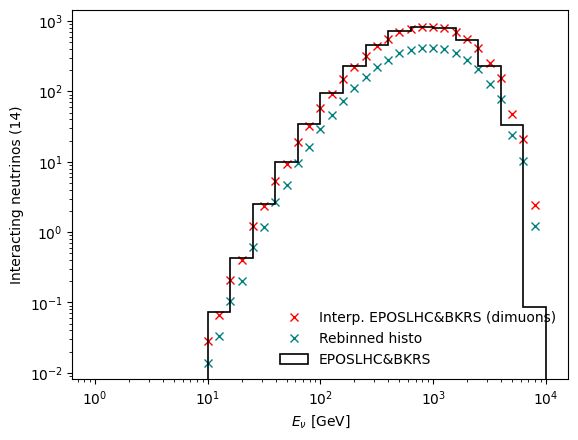

Integrals:
Original spectrum: 3988.5190556483967
Rebinning (before norm.): 7956.403533533848
Rebinning (normalized): 3988.519055648397


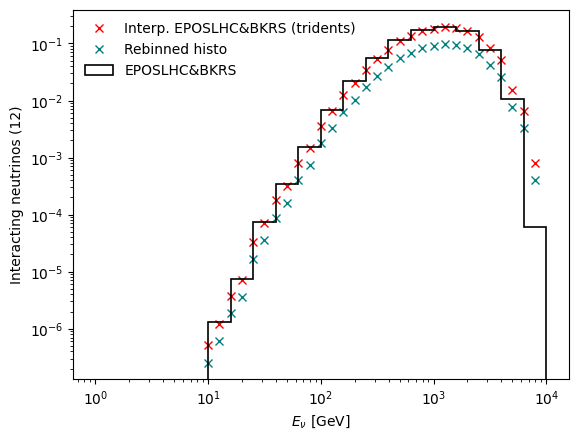

Integrals:
Original spectrum: 0.8224108328296461
Rebinning (before norm.): 1.6384126670802703
Rebinning (normalized): 0.8224108328296463


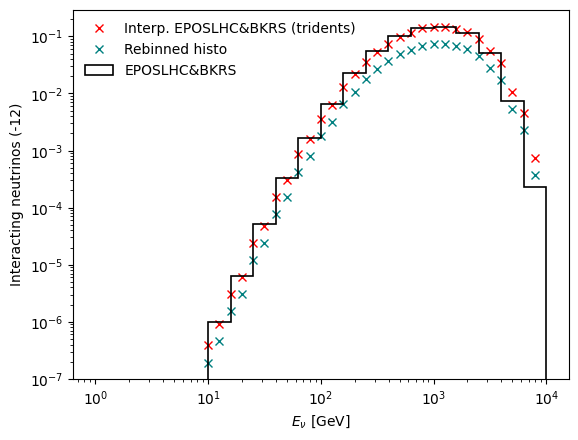

Integrals:
Original spectrum: 0.6515410306789273
Rebinning (before norm.): 1.298781340381819
Rebinning (normalized): 0.6515410306789272


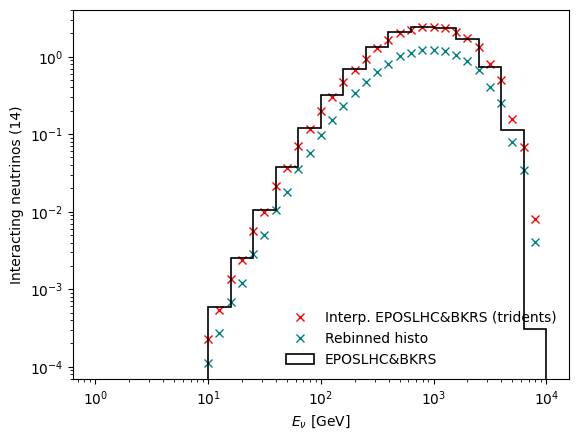

Integrals:
Original spectrum: 11.910590771139505
Rebinning (before norm.): 23.753123504933118
Rebinning (normalized): 11.910590771139503


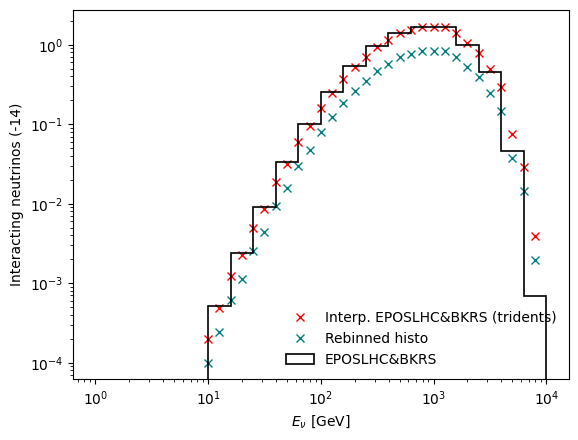

Integrals:
Original spectrum: 8.197854222959492
Rebinning (before norm.): 16.367771892781768
Rebinning (normalized): 8.197854222959496


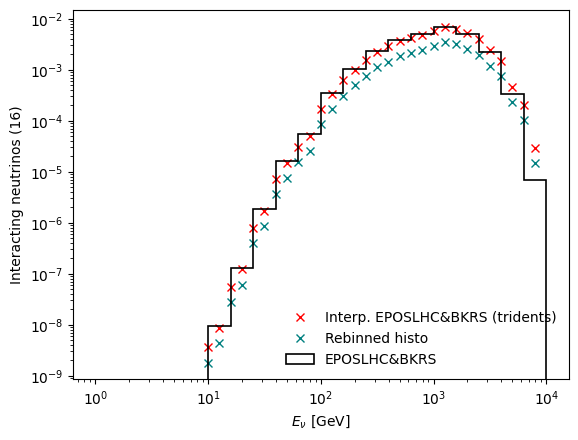

Integrals:
Original spectrum: 0.02693686000446088
Rebinning (before norm.): 0.053679526097815025
Rebinning (normalized): 0.02693686000446087


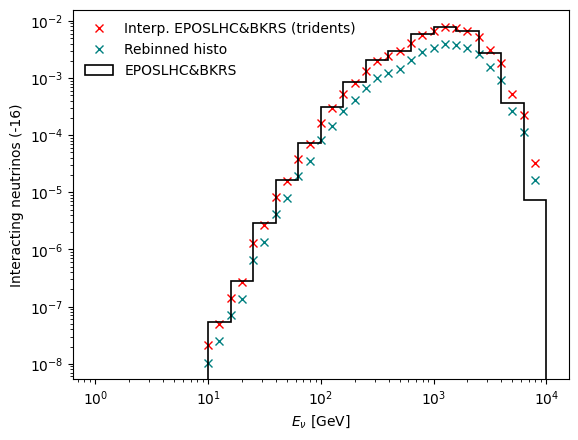

Integrals:
Original spectrum: 0.029856232129796094
Rebinning (before norm.): 0.05949620210452478
Rebinning (normalized): 0.029856232129796094


In [23]:
rebinwgt={}

rebinwgt[genpairBLstr]={}
for detec in detectors:
    rebinwgt[genpairBLstr][detec]={}
    for proc in ['dimuons','tridents']:
        rebinwgt[genpairBLstr][detec][proc]={}
        for nuid in ['14'] if proc=='dimuons' else vpidstrs:
            rebinwgt[genpairBLstr][detec][proc][nuid] = spectraRebin(detector=detec,genpair=genpairBL,\
                                                                     normproc=proc,nuid=nuid)

## Functions to read external-MC-produced data 

### Dimuon background

Function to read all entries in the file corresponding to iE:th energy value in the SM dimuon files produced w/ PYTHIA.

The columns in the MC file contain:
- 0:      event number
- 1:      name of the initial quark, mostly "s", which is strange quark
- 2:      the Q of DIS,  Q^2 = -q^2, where q is the transferred momentum to the hadronic side
- 3, 4:   the x of DIS. 4 and 5 are two definitions
- 5--8:   E, px, py, pz of the muon from leptonic vertex
- 9--12:  E, px, py, pz of the 2nd muon
- 13--17: name, E, px, py, pz of the 2nd muon's mother particle (usually a D meson)
- 18--21: E, px, py, pz of the 3rd muon (usually there no 3rd muon, so mostly 0 0 0 0)
- 22--26: name, E, px, py, pz of the 3rd muon's mother particle (usually no 3rd muon, mostly 0 0 0 0 0)
- 27--30: E, px, py, pz of the 4th muon (usually no 4th muon, so mostly 0 0 0 0)
- 31--35: name, E, px, py, pz of the 4th muon's mother particle (usually no 4th muon, mostly 0 0 0 0 0)

In [24]:
#Define the cuts that can already be checked at the stage of reading individual E-bin P8 files
LdecMax=0.002  #Maximum decay length [m]
thetaMax=0.1 #0.02, angle between 1st and 2nd muon
NchMax=2  #Max number of charged tracks

#N.B. Energy bin index iE >= 1
def readDimuonsBin(iE,generator,detector,nuid):
    striE = str(iE)
    if iE<10: striE = '0' + striE
    fname = datadir + '37_' + striE + '_all.txt'
    ret={}
    #Ensure file is not empty
    isEmpty = False
    ret['empty'] = (os.stat(fname).st_size == 0)
    if ret['empty']:
        print('Dimuon file empty at iE = '+str(iE))
        isEmpty = True
    #Read events' kinematic info
    ret['evnum'] = [] if isEmpty else np.genfromtxt(fname,usecols=0,dtype='int')
    ret['qname'] = [] if isEmpty else np.genfromtxt(fname,usecols=1,dtype='str')
    ret['Q2'   ] = [] if isEmpty else np.genfromtxt(fname,usecols=2,dtype='float')
    ret['x'    ] = [] if isEmpty else np.genfromtxt(fname,usecols=3,dtype='float')
    ret['Enu'  ] = [] if isEmpty else np.multiply(Evals[iE-1],np.ones(ret['x'].size))  #Evals index>0, but iE>1
    #1st muon, from leptonic vertex
    ret['E_1' ] = [] if isEmpty else np.genfromtxt(fname,usecols=5,dtype='float')
    ret['px_1'] = [] if isEmpty else np.genfromtxt(fname,usecols=6,dtype='float')
    ret['py_1'] = [] if isEmpty else np.genfromtxt(fname,usecols=7,dtype='float')
    ret['pz_1'] = [] if isEmpty else np.genfromtxt(fname,usecols=8,dtype='float')
    #2nd muon
    ret['E_2' ] = [] if isEmpty else np.genfromtxt(fname,usecols=9,dtype='float')
    ret['px_2'] = [] if isEmpty else np.genfromtxt(fname,usecols=10,dtype='float')
    ret['py_2'] = [] if isEmpty else np.genfromtxt(fname,usecols=11,dtype='float')
    ret['pz_2'] = [] if isEmpty else np.genfromtxt(fname,usecols=12,dtype='float')
    #Mother particle of 2nd muon
    ret['name_2m'] = [] if isEmpty else np.genfromtxt(fname,usecols=13,dtype='str')
    ret['E_2m'   ] = [] if isEmpty else np.genfromtxt(fname,usecols=14,dtype='float')
    ret['px_2m'  ] = [] if isEmpty else np.genfromtxt(fname,usecols=15,dtype='float')
    ret['py_2m'  ] = [] if isEmpty else np.genfromtxt(fname,usecols=16,dtype='float')
    ret['pz_2m'  ] = [] if isEmpty else np.genfromtxt(fname,usecols=17,dtype='float')
    #3rd muon
    ret['E_3' ] = [] if isEmpty else np.genfromtxt(fname,usecols=18,dtype='float')
    ret['px_3'] = [] if isEmpty else np.genfromtxt(fname,usecols=19,dtype='float')
    ret['py_3'] = [] if isEmpty else np.genfromtxt(fname,usecols=20,dtype='float')
    ret['pz_3'] = [] if isEmpty else np.genfromtxt(fname,usecols=21,dtype='float')
    #Mother particle of 3rd muon
    ret['name_3m'] = [] if isEmpty else np.genfromtxt(fname,usecols=22,dtype='str')
    ret['E_3m'   ] = [] if isEmpty else np.genfromtxt(fname,usecols=23,dtype='float')
    ret['px_3m'  ] = [] if isEmpty else np.genfromtxt(fname,usecols=24,dtype='float')
    ret['py_3m'  ] = [] if isEmpty else np.genfromtxt(fname,usecols=25,dtype='float')
    ret['pz_3m'  ] = [] if isEmpty else np.genfromtxt(fname,usecols=26,dtype='float')
    #4th muon
    ret['E_4' ] = [] if isEmpty else np.genfromtxt(fname,usecols=27,dtype='float')
    ret['px_4'] = [] if isEmpty else np.genfromtxt(fname,usecols=28,dtype='float')
    ret['py_4'] = [] if isEmpty else np.genfromtxt(fname,usecols=29,dtype='float')
    ret['pz_4'] = [] if isEmpty else np.genfromtxt(fname,usecols=30,dtype='float')
    #Mother particle of 4th muon
    ret['name_4m'] = [] if isEmpty else np.genfromtxt(fname,usecols=31,dtype='str')
    ret['E_4m'   ] = [] if isEmpty else np.genfromtxt(fname,usecols=32,dtype='float')
    ret['px_4m'  ] = [] if isEmpty else np.genfromtxt(fname,usecols=33,dtype='float')
    ret['py_4m'  ] = [] if isEmpty else np.genfromtxt(fname,usecols=34,dtype='float')
    ret['pz_4m'  ] = [] if isEmpty else np.genfromtxt(fname,usecols=35,dtype='float') 
    
    #Ensure format
    for key in ret.keys():
        if key=='empty': continue
        if not isEmpty and sum(ret[key].shape)==0: 
            ret[key] = np.array([ret[key]])
        if not isinstance(ret[key],list): ret[key] = ret[key].tolist()
            
    #Turn evnum list of non-unique ids to unique ids by combining with E-bin index
    ret['evnum'] = [] if isEmpty else [str(evnum) + '_' + str(iE) for evnum in ret['evnum']]

    #Check expected number of events in a realistic spectrum at this fixed Enu
    #N.B. rebinned index corresponds to Evals, i.e. >=0
    spectrawgt = 0 if isEmpty else rebinwgt[generator][detector]['dimuons'][nuid][iE-1]/len(ret['evnum'])
    ret['spectrawgt'] = [] if isEmpty else [spectrawgt for evnum in ret['evnum']]

    ret['theta_12']=[]  #Init
    ret['d_2m']=[]  #Init
    if not isEmpty:
        for i in range(len(ret['evnum'])):
            #Angle between muons 1 and 2
            p1i = [ret['px_1'][i],ret['py_1'][i],ret['pz_1'][i]]
            p2i = [ret['px_2'][i],ret['py_2'][i],ret['pz_2'][i]]           
            muonAngle = np.arccos(np.dot(p2i,p1i)/(np.sqrt(np.dot(p1i,p1i)*np.dot(p2i,p2i))))
            ret['theta_12'].append(muonAngle)    
            #2nd muon parent decay lengths
            ret['d_2m'].append(decayLength(name=ret['name_2m'][i],\
                                           px=ret['px_2m'][i],py=ret['py_2m'][i],pz=ret['pz_2m'][i]))        

    return ret

### Trident signal

Function to read all entries in the file corresponding to iE:th energy value in the 
trident files produced w/ modified W. Altmannshofer's code 

N.B.:

1) Energy bin index iE >= 1
2) The SM/BSM cases's behavior is similar, need to do this for SM only

In [25]:
def readTridentsBin(iE,generator,detector,nuid):
    
    if '_' in generator: material = generator.split('_')[-1]
    else: material = experiments[detector]['material']
    
    nustr='nu'
    if int(nuid)<0: nustr += 'bar'
    if   abs(int(nuid))==12: nustr += 'el'
    elif abs(int(nuid))==16: nustr += 'tau'
    else:                    nustr += 'mu'
    
    striE = str(iE)
    if iE<10: striE = '0' + striE
    fname = 'files/trident_mc/tridents/generated_events/'+material+'_SM_'+ nustr + '_' + striE + '.txt'
    ret={}
    ret['px_2']=[]
    ret['py_2']=[]
    ret['pz_2']=[]
    ret['E_2']=[]
    ret['px_1']=[]
    ret['py_1']=[]
    ret['pz_1']=[]
    ret['E_1']=[]
    ret['Enu']=[]
    ret['theta_12']=[]
    ret['spectrawgt']=[]
    #Ensure file is not empty
    ret['empty'] = (os.stat(fname).st_size == 0)
    if ret['empty']:
        print('Trident file empty at iE = '+str(iE))
        return ret

    #Here we only consider the production of a mu-mubar pair
    lepton1 = int(nuid)/abs(int(nuid))*13
    lepton2 = -1*lepton1
    #If we wouldn't only consider dimuon production, could deduce lepton 1 & 2 PDG IDs (left for reference):
    #lepton1 = int(nuid)/abs(int(nuid))*(abs(int(nuid))-1)
    #lepton2 = -1*lepton1
    
    f = open(fname, "r")
    lines=[]
    lines=f.readlines()
    f.close()
    inEvt = False  #Flag if currently reading event lines
    mu1found = False
    mu2found = False
    Enufound = False
    p4_1 = [0.,0.,0.,0.]
    p4_2 = [0.,0.,0.,0.]
    for line in lines:
        #Check where event listings start and end
        if  '<event>' in line: 
            inEvt = True
            mu1found = False
            mu2found = False
            Enufound = False
            p4_1 = [0.,0.,0.,0.]
            p4_2 = [0.,0.,0.,0.]
            continue
        if '</event>' in line: 
            inEvt = False
            continue
        if inEvt:
            lsplit = line.split()
            if lsplit[0]==nuid and lsplit[1]=='-1' and not Enufound: 
                ret['Enu'].append(float(lsplit[5]))
                Enufound = True
            elif int(lsplit[0])==lepton2 and lsplit[1]=='1' and not mu2found: 
                mu2found = True
                p4_2 = [float(lsplit[2]), float(lsplit[3]), float(lsplit[4]), float(lsplit[5])]
            elif int(lsplit[0])==lepton1 and lsplit[1]=='1' and not mu1found: 
                mu1found = True
                p4_1 = [float(lsplit[2]), float(lsplit[3]), float(lsplit[4]), float(lsplit[5])]
            else: 
                continue
            if mu1found and mu2found:
                ret['px_1'].append(p4_1[0])
                ret['py_1'].append(p4_1[1])
                ret['pz_1'].append(p4_1[2])
                ret['E_1' ].append(p4_1[3])
                ret['px_2'].append(p4_2[0])
                ret['py_2'].append(p4_2[1])
                ret['pz_2'].append(p4_2[2])
                ret['E_2' ].append(p4_2[3])
                #Angle between muons 1 and 2
                p1i = [ret['px_1'][-1],ret['py_1'][-1],ret['pz_1'][-1]]
                p2i = [ret['px_2'][-1],ret['py_2'][-1],ret['pz_2'][-1]]           
                ret['theta_12'].append(np.arccos(np.dot(p2i,p1i)/(np.sqrt(np.dot(p1i,p1i)*np.dot(p2i,p2i)))))
                
    #Check expected number of events in a realistic spectrum at this fixed Enu
    #N.B. rebinned index corresponds to Evals, i.e. >=0
    spectrawgt = rebinwgt[generator][detector]['tridents'][nuid][iE-1]/len(ret['Enu'])
    ret['spectrawgt'] = [spectrawgt for i in range(len(ret['Enu']))]
        
    return ret

## Process full Pythia event listing, check charged track multiplicity

Read all events in the full Pythia8 output particle listing and finds $N$-muon evts, all of which are originally assigned a non-unique event id in the file. The id is made unique here by combining with $E_\nu$-bin index.
This is used in particular to check the charged track multiplicity, ergo the number of charged particles in the dimuon sample, with momentum above a given cut-off.

Param:
- `pCutOff`: only consider charged tracks with total momentum above this threshold [GeV]

Returns:

A dictionary of the N-muon evts, with the new unique ids as first keys. 
Then each evt has the key 
- `Enu`:      incoming neutrino energies corresponding to the events^
- `evtlines`: if store_evtlines==True, returns the lines in the MC file corresponding to each event
- `Nch`:      number of charged tracks w/ p>pCutOff in the event


In [26]:
def readFullP8output(pCutOff):

    #Init
    inEvt = False       #True when currently reading an event  
    Nevt=0    #Stepper to count total number ot events
    ret={}
    evtlines=[]
    
    #Read Pythia output
    f = open(datadir+'0000_all_particles.txt', "r")
    lines=[]
    lines=f.readlines()
    f.close()

    for i in range(len(lines)):
            
        if 'PYTHIA Event Listing  (complete event)' in lines[i]:
            Nevt += 1
            evtlines = []  #Reinit/clear
            EnuEvt = 0.
            Nch = 0       #Stepper to count charged particles
            Nmu = 0       #Count muons in event
            inEvt = True  #Event-reading phase entered
            mudtrs=[]  #Store mu dtrs' number in P8 output, to not double-count mus emitting radiation
            continue
    
        if inEvt:
            if 'Charge sum:' not in lines[i]:
                if store_evtlines: evtlines.append(lines[i])
                lsplit = lines[i].split()
                if not len(lsplit)==0 and 'id  name' not in lines[i]:
                    pdgid  = int(lsplit[1])
                    name   = lsplit[2]
                    status = int(lsplit[3])
                    #Incoming particles have status +-12, check incident E_nu 
                    if abs(status)==12 and 'nu' in name: 
                        EnuEvt = float(lsplit[13])
                    #Check charged final state particles
                    elif '(' not in name and ('+' in name or '-' in name) and not abs(status)==12: 
                        px = float(lsplit[10])
                        py = float(lsplit[11])
                        pz = float(lsplit[12])
                        if np.sqrt(px**2 + py**2 + pz**2) > pCutOff: Nch += 1
                    #Count muons: ensure considered events have >=2 muons to be dimuon
                    if '(' not in name and abs(pdgid)==13 and lsplit[0] not in mudtrs: 
                        Nmu += 1
                        mudtrs.append(lsplit[6])  #Store indices of muons' daughter particles in the evt.
                        mudtrs.append(lsplit[7])
            #Finished reading this event, store or discard before moving to next one
            else:
                inEvt = False
                #Skip lines between 'Charge sum' line and possible 'iEvent' id-assignment line
                while i<len(lines) and 'End PYTHIA Event Listing' not in lines[i-1]: i+=1
                #Ensure this event was assigned a non-unique id in the file, i.e. labeled as an N-muon event
                if 'iEvent' in lines[i] and Nmu >= 2:
                    #Make event ids unique by combining them with E-bin id
                    idstr = lines[i].split()[4]           #Check assigned id
                    if idstr[-1]==',': idstr=idstr[:-1]   #Remove tailing ','
                    idstr += '_' + str(iEfinder(EnuEvt))
                    ret[idstr] = {}
                    ret[idstr]['Enu'] = EnuEvt
                    ret[idstr]['Nch'] = Nch
                    ret[idstr]['evtlines'] = evtlines
    print('Total number of events in Pythia file: '+str(Nevt))
    print('Events with at least two muons: '+str(len(list(ret.keys()))))
    return ret

In [27]:
#Fetch multiplicity cutoff results only according to the P8 file, not convoluted w/ realistic spectra yet
pCutOff = 0.3
P8out = readFullP8output(pCutOff = pCutOff)

Total number of events in Pythia file: 22598
Events with at least two muons: 22562


### Store all events in a dictionary complex
This is done to combine the information from individual E-bin files and the full Pythia output. 
Also, this avoids reading ASCII files repeatedly.

In [28]:
def readBins(proc,genpairstr,detector,nuid):
    ret={}
    for iE in range(1,len(Evals)+1):
        if proc=='tridents':
            #To avoid confusion w/ num. indices starting at 0, give iE bin here as a string index >1
            ret[str(iE)] = readTridentsBin(iE,genpairstr,detector,nuid)
        elif proc=='dimuons':
            ret[str(iE)] = readDimuonsBin(iE,genpairstr,detector,nuid)
            #Store P8 bg ch. track multip.
            ret[str(iE)]['Nch'] = [P8out[evn]['Nch'] for evn in ret[str(iE)]['evnum']]
    return ret

Init a global object containing the info of MC bins. 
Due to limited memory resources, all the MC information cannot be stored at once. 
Nonetheless, reading the MC files again each time they are needed in a function and immediately releasing the memory is also suboptimal, since several functions require the data of the same MC file. 
Optimally, such functions should be placed one after the other, and the contents of the global `mcbins` object are only replaced if `fetchmc` is called with inputs different to the last call.

In [29]:
mcbins={}
#Store last input arguments to fetchmcbins. Init st first call will certainly find mcbins
mcbins_lastgenpairstr = ''
mcbins_lastdetector = ''
mcbins_lastinprocs = []

def fetchmcbins(genpairstr,detector,inprocs=['dimuons','tridents']):

    global mcbins
    global mcbins_lastgenpairstr
    global mcbins_lastdetector
    global mcbins_lastinprocs
    
    #Check if mcbins must be recomputed/reused
    reusemcbins = (mcbins_lastgenpairstr == genpairstr) and (mcbins_lastdetector == detector)
    for inproc in inprocs:
        #TODO both procs can't be stored in the future w/ all large files, rm this feature
        #     just check if inprocs == mcbins_lastinprocs:
        if inproc not in mcbins_lastinprocs: reusemcbins = False
    
    if not reusemcbins:
        mcbins_lastgenpairstr = genpairstr
        mcbins_lastdetector = detector
        mcbins_lastinprocs = inprocs
        mcbins = {}  #Reinit global "return object"
        for proc in inprocs:
            mcbins[proc]={}
            if   proc=='dimuons':  nuidvec=['14']
            elif proc=='tridents': nuidvec=vpidstrs
            else: print('WARNING: fetchmcbins cannot handle proc='+proc)
            for nuid in nuidvec:
                mcbins[proc][nuid] = readBins(proc,genpairstr,detector,nuid)
        print('Read MC bins for '+detector+', '+genpairstr)

## Investigate D meson parents of 2nd muon

In [30]:
def checkDimuonParents():
    #Check which parent mesons remain untreated, for all energies -- normalization does not matter for listing
    otherMesons=[]  #To store whatever was found in file but not included in histos
    #Store evt. id.s of the rare cases where parent is a mu+ or tau+ instead of a hadron
    muptaupevtidstrs=[]
    
    #Doesn't really matter which detector this is called for, as long as it is included
    global mcbins
    fetchmcbins(genpairstr=genpairBLstr,detector=detectors[0],inprocs=['dimuons'])
    
    for iE in range(1,len(Evals)+1):

        tmp = mcbins['dimuons']['14'][str(iE)]

        if not tmp['empty']:
            for i in range(len(tmp['x'])):
                #Ensure 2nd muon w/ momentum > 0 exists
                if tmp['E_2' ][i]==0 and tmp['px_2'][i]==0 and tmp['py_2'][i]==0 and tmp['pz_2'][i]==0:
                    print('WARNING encountered event w/o/ 2nd muon')
                    continue        
                name2m = tmp['name_2m'][i]  #Abbreviation for the name of 2nd muon parent hadron
                if name2m in Dmesons: continue
                elif name2m not in otherMesons: otherMesons.append(name2m)
                if name2m in ['mu+','tau+']: 
                    muptaupevtidstrs.append(tmp['evnum'][i])
        numtmp = len(tmp['E_2' ])
        numtmp = 1.0 if numtmp==0 else numtmp

    print('Parent mesons other than D: ',otherMesons)            
    #print('Evt IDs with mu as parent: ',muptaupevtidstrs)

checkDimuonParents()

Dimuon file empty at iE = 1
Dimuon file empty at iE = 2
Dimuon file empty at iE = 3
Dimuon file empty at iE = 4
Dimuon file empty at iE = 6
Read MC bins for FASERv2, EPOSLHC&BKRS
Parent mesons other than D:  ['omega', 'Lambda0', 'Lambda_c+', 'eta', 'rho0', 'mu+', 'Sigma-', 'tau+', 'mu-', "eta'", 'Xi_c+', 'Lambdabar0', 'Xi_c0', 'Sigmabar+', 'phi', 'D-', 'Dbar0', 'Xibar+', 'D_s-', 'Omega_c0', 'Xi-', 'tau-', 'B-', 'B0', 'Bbar0', 'Lambda_bbar0', 'Lambda_cbar-', 'Xi_cbar0', 'B+', 'B_sbar0', 'Xi_bbar0']


### Fraction of events with less than 3 muons out of all events

E-bin 1: E=1.0, R=0.0
E-bin 2: E=1.25892541, R=0.0
E-bin 3: E=1.58489319, R=0.0
E-bin 4: E=1.99526231, R=0.0
E-bin 5: E=2.51188643, R=0.0
E-bin 6: E=3.16227766, R=0.0
E-bin 7: E=3.98107171, R=0.5
E-bin 8: E=5.01187234, R=1.0
E-bin 9: E=6.30957344, R=0.9
E-bin 10: E=7.94328235, R=0.8235294117647058
E-bin 11: E=10.0, R=0.8947368421052632
E-bin 12: E=12.5892541, R=0.9550561797752809
E-bin 13: E=15.8489319, R=0.8896551724137931
E-bin 14: E=19.9526231, R=0.9797297297297297
E-bin 15: E=25.1188643, R=0.961352657004831
E-bin 16: E=31.6227766, R=0.9745454545454545
E-bin 17: E=39.8107171, R=0.9659442724458205
E-bin 18: E=50.1187234, R=0.9538904899135446
E-bin 19: E=63.0957344, R=0.9640883977900553
E-bin 20: E=79.4328235, R=0.970917225950783
E-bin 21: E=100.0, R=0.9549902152641878
E-bin 22: E=125.892541, R=0.9701492537313433
E-bin 23: E=158.489319, R=0.9512195121951219
E-bin 24: E=199.526231, R=0.95260663507109
E-bin 25: E=251.188643, R=0.9654135338345865
E-bin 26: E=316.227766, R=0.9600570613409

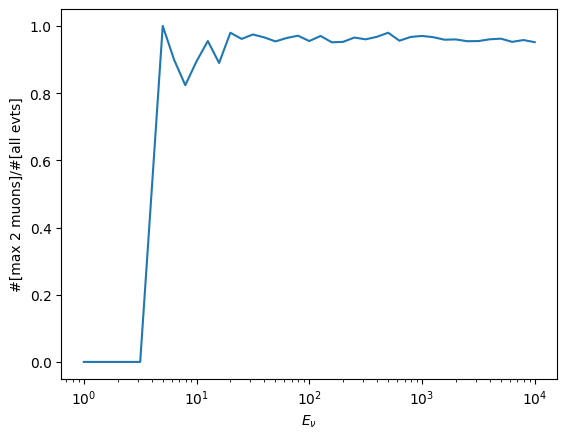

In [31]:
def check_R_max2muons():
    R_max2muons=[]
    #Doesn't really matter which detector is called, as long as it is included
    global mcbins
    fetchmcbins(genpairstr=genpairBLstr,detector=detectors[0],inprocs=['dimuons'])
    for iE in range(1,len(Evals)+1):
        max2muons=0
        tmp = mcbins['dimuons']['14'][str(iE)]
        if not tmp['empty']:
            for i in range(len(tmp['x'])):
                if tmp['name_3m'][i]=='0': max2muons+=1
        numtmp = len(tmp['E_2' ])
        numtmp = 1.0 if numtmp==0 else numtmp
        R_max2muons.append(max2muons/numtmp)
    
    for i in range(len(Evals)):
        print('E-bin '+str(i+1)+': E='+str(Evals[i])+', R='+str(R_max2muons[i]))
    plotTest(plt.plot(Evals,R_max2muons),\
             testsubdir = 'dimuons-tridents',\
             testtag = codename+'_2_mu_vs_all',\
             mode = 'plot')
    plt.xscale('log')
    plt.xlabel(r'$E_\nu$')
    plt.ylabel(r'#[max 2 muons]/#[all evts]')
    plt.savefig('plots/2_mu_vs_all.pdf')

check_R_max2muons()

In [32]:
def check_qnames(proc):
    qnames=[]
    #Doesn't matter which detector is called, as long as it is included
    global mcbins
    fetchmcbins(genpairstr=genpairBLstr,detector=detectors[0],inprocs=[proc])
    for iE in range(1,len(Evals)+1):
        tmp = mcbins[proc]['14'][str(iE)]
        if not tmp['empty']:
            for qname in tmp['qname']:
                if qname not in qnames: qnames.append(qname)
    print('All quark names associated with some '+proc+' event: ',qnames)

check_qnames(proc='dimuons')

All quark names associated with some dimuons event:  ['d', 's', 'cbar', 'ubar']


## 1D projection of the charged track multiplicity, integrated over $E_\nu$

In [33]:
def projectNch(detector):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0.16, 0.12, 0.82, 0.82])
    matplotlib.rcParams.update({'font.size': 14})

    global mcbins
    fetchmcbins(genpairstr=genpairBLstr,detector=detector,inprocs=['dimuons'])
    allNch = []
    allEnu = []
    allWgt = []
    for iE in range(1,len(Evals)+1):
        allNch = allNch + list(mcbins['dimuons']['14'][str(iE)]['Nch'])
        allEnu = allEnu + list(mcbins['dimuons']['14'][str(iE)]['Enu'])
        allWgt = allWgt + list(mcbins['dimuons']['14'][str(iE)]['spectrawgt'])
    
    #Plot all evts, weights based on convolution with baseline generator spectrum
    Nchbins = range(0,30,2)
    plt.hist([], bins=Nchbins, histtype='bar', color='gray', ls='solid', lw=1.2)
    histo = plt.hist(allNch,\
                     bins=np.add(-0.5,Nchbins),\
                     weights=allWgt,\
                     histtype='bar', color='gray', ls='solid', lw=1.2)
    plotTest(histo,\
             testsubdir = 'dimuons-tridents',\
             testtag = codename+'_projectNch_'+detector,\
             mode = 'histo')

    plt.plot([2.5,2.5], [0,3000], linestyle='dashed', color='black')
    plt.title(genpairBLstr+r', '+detector.replace('FASERv',r'FASER$\nu$'))
    savename='plots/ch_track_multiplicity_1D_'+detector+'.pdf'
    
    #Plot style setup, save file
    matplotlib.rcParams.update({'axes.labelsize':'large'})
    matplotlib.rcParams.update({'axes.titlesize':'large'})
    plt.ylabel(r'B.g. events with $\geq$ 2 muons')
    plt.xlabel(r'#Charged FS particles w/ $p>'+str(pCutOff)+r'$ GeV')
    plt.yscale('log')
    plt.xlim(0,27.5)
    plt.ylim(1e-2,2000)
    print('Saving image '+savename)
    plt.savefig(savename)
    plt.show()
    
    integral = sum( [ histo[0][i]*( histo[1][i+1] - histo[1][i] ) for i in range(len(histo[0])) ] )
    print('Integral of the histo = '+str(integral))

#Plot b.g. illustrations only if experimental efficiencies not considered
if not useAcc:
    projectNch(detector=detectors[0])

# Apply cuts to find the rate of accepted events. 
The most important cuts would be sth like
     a) parent hadron decay length < 2mm (dimuons only)
     b) opening angle between muons < 20 mrad
     c) multiplicity = 2 for charged tracks with momentum p > 300 MeV 
in order to study how many b.g. events could not be distinguished from trident events due to resolution effects.

Parameters (default values render the particular cut ineffective):
- `detector` The detector to be used as a key for the `mcbins` object, e.g. 'FASERv2'
- `pred` The prediction pair assumed as baseline, e.g. 'SIBYLL&SIBYLL'
- `proc` The process to study: 'tridents' for signal, 'dimuons' for b.g.
- `vpidst` Neutrino PDG ID as a string
- `Donly` Restrict to processes where 2nd muon parent is a D meson
- `dMax` Maximum decay length ($d$), cut evt.s with $d$ above these ('dimuons' only!)
- `angleMax` Maximum angle between the two muons
- `NchCut` Cut events with more charged final state particles
- `Ebins` The cuts are returned as a ratio $f(E) \in [0,1]$, evaluated at the energies given here
- `quarks` To study the contribution of evts associated with e.g. an $s$ quark vs $u$ and $d$ quarks, cut all events not corresponding to quarks given in the list. Ineffective if list is empty.
- `logname` If given, print accepted events' lines in P8 output to this file

In [34]:
def findCuts(detector,pred,proc,vpidstr,\
             Donly=False,dMax=-1,angleMax=-1,NchCut=-1,NmuMin=-1,NmuMax=-1,\
             Ebins=[],quarks=[],logname=''):
    accRatios=[]
    accs=[]
    global mcbins
    fetchmcbins(genpairstr=genpairBLstr,detector=detector,inprocs=[proc])
    #Evals indices start from 1 in the filenames   
    for iE in range(1,len(Evals)+1):
        tmp = mcbins[proc][vpidstr][str(iE)]
        acc=[]
        if len(list(tmp.keys()))<2 and 'empty' in list(tmp.keys()):
            accRatios.append(0.)
            continue           
        for i in range(len(tmp['E_1'])):
            #Check that angle between muons is sufficiently small
            if angleMax > 0. and tmp['theta_12'][i] > angleMax: continue
            if proc=='dimuons':
                #Check that event index is w/in those passing charged track multiplicity cut
                if NchCut>0 and tmp['Nch'][i]>NchCut: continue  #N.B. p cut applied in readFullP8output(pCutOff)
                #Restrict to evts associated w/ particular quarks if requested
                if len(quarks)!=0 and tmp['qname'][i] not in quarks: continue
                #Restrict to evts w/ requested min amount of muons with an assigned parent particle
                if NmuMin>0 and tmp['name_'+str(NmuMin)+'m'][i]=='0': continue
                #Restrict to evts w/ requested max amount of muons with an assigned parent particle
                if NmuMax>0:
                    if   NmuMax<=2 and tmp['name_3m'][i]!='0': continue
                    elif NmuMax<=3 and tmp['name_4m'][i]!='0': continue  #The files list up to 4-muon events
                #Check that 2nd muon parent decay length > cut-off
                if not Donly or tmp['name_2m'][i] in Dmesons:
                    if dMax > 0. and tmp['d_2m'][i] > dMax: continue
                    acc.append(str(i)+'_'+str(iE) if proc!='dimuons' else tmp['evnum'][i])
            #No parent information for other processes, simply add evnum to accepted events
            else: acc.append(str(i)+'_'+str(iE) if proc!='dimuons' else tmp['evnum'][i])
        #Append ratio of uncut evts to all evts in the bin to a list
        accRatios.append(0.0 if len(tmp['E_1'])==0 else len(acc)/len(tmp['E_1']))
        accs.append(deepcopy(acc))
    #Print accepted dimuon bg events P8 output lines if logfilename given
    if len(logname)!=0 and proc=='dimuons' and len(accs)!=0 and store_evtlines: 
        print('findCuts printing accepted events to file '+logname)
        f = open(logname, "w")
        for accsentry in accs:
            for accevnum in accsentry:
                for line in P8out[accevnum]['evtlines']: f.write(line)
                f.write('\n')
        f.close()                
    #Interpolate and return arbitrarily-binned histo,
    #If no binning specified, return accRatios corresponding to P8 bins 
    #Else interpolate and return a ratio corresponding to the given binning
    if len(Ebins)==0: return accRatios
    fip = interpolate.interp1d(Evals,accRatios,fill_value='extrapolate')
    f = np.array([fip(E) for E in Evals])
    return [fip(E) for E in Ebins]

### Check fraction of events where 2nd muon parent is a D meson, test findCuts and interpolation properties

A handle for producing 1D plots to avoid boilerplate
- `datasets`       Array of datasets to plot: [[x-data, y-data]_dataset1, [x-data, y-data]_dataset2, ...]
- `labels`         List of labels for the datasets, for legend
- `titles`         [Plot title, x-axis title, y-axis title]
- `logs`           Use log x and y axes, respectively? E.g. [True,False] for log x, lin y
- `xlims`,`ylims`  Lower and higher limits for x and y axes, respectively
- `savename`       If not '', store produced plot into this filepath


In [35]:
proc='dimuons'
detector=detectors[0]

def plot1D(datasets,labels,titles,logs,xlims,ylims,savename):
    plt.clf()
    matplotlib.rcParams.update({'font.size': 14})
    testname = savename.split('/')[-1]  #No further subdirs for test output
    for i,data in enumerate(datasets):
        if len(labels)==len(datasets): 
            plotTest(plt.plot(data[0],data[1],label=labels[i]),\
                     testsubdir = 'dimuons-tridents',\
                     testtag = codename+'_plot1D_'+testname+'_'+str(i),\
                     mode = 'plot')
        else: 
            plotTest(plt.plot(data[0],data[1]),\
                     testsubdir = 'dimuons-tridents',\
                     testtag = codename+'_plot1D_'+testname+'_'+str(i),\
                     mode = 'plot')
    plt.title(titles['main'])
    plt.xlabel(titles['x'])
    plt.ylabel(titles['y'])
    if logs[0]: plt.xscale('log')
    if logs[1]: plt.yscale('log')
    if len(xlims)==2: plt.xlim(xlims[0],xlims[1])
    if len(ylims)==2: plt.ylim(ylims[0],ylims[1])
    if len(labels)==len(datasets): plt.legend(frameon=False)
    if len(savename)>0:
        print('Saving image '+savename)
        plt.savefig(savename)
    plt.show()

Saving image plots/D_mesons_vs_all.pdf


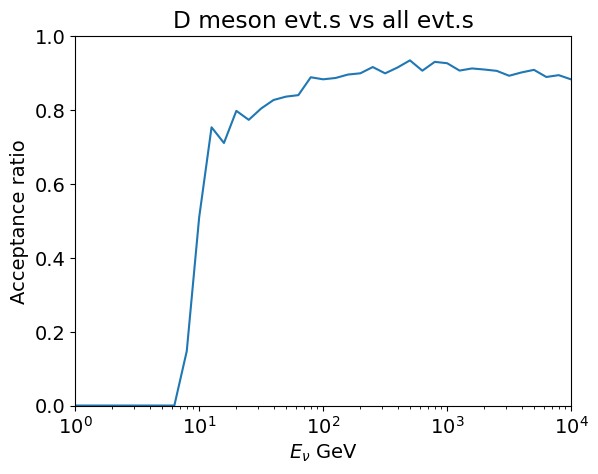

Saving image plots/D_mesons_vs_all_ecenters.pdf


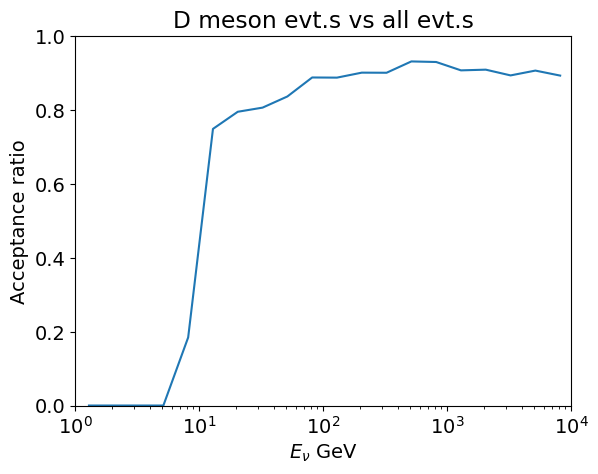

In [36]:
#Plot ratio of #[D meson evts] vs #[all evts]
plot1D(datasets=[[Evals,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',\
                                 Donly=True,dMax=-1.,angleMax=-1.)]],\
       labels=[],
       titles={'main':'D meson evt.s vs all evt.s', 'x':r'$E_\nu$ GeV', 'y':r'Acceptance ratio'},\
       logs=[True,False],xlims=[1.0,1e4],ylims=[0.0,1.0],savename='plots/D_mesons_vs_all.pdf')

#Check how the above ratio looks like when interpolating at the spectra plots' E-bin centers
ebins = np.array(model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros))['14']['ebins'])
ecenters = (ebins[1:]+ebins[:-1])/2
plot1D(datasets=[[ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',Donly=True,dMax=-1.,angleMax=-1.,Ebins=ecenters)]],\
       labels=[],
       titles={'main':'D meson evt.s vs all evt.s', 'x':r'$E_\nu$ GeV', 'y':r'Acceptance ratio'},\
       logs=[True,False],xlims=[1.0,1e4],ylims=[0.0,1.0],savename='plots/D_mesons_vs_all_ecenters.pdf')


### Decay length cut only

Saving image plots/dimuons_decay_length_cut_survival_ratio.pdf


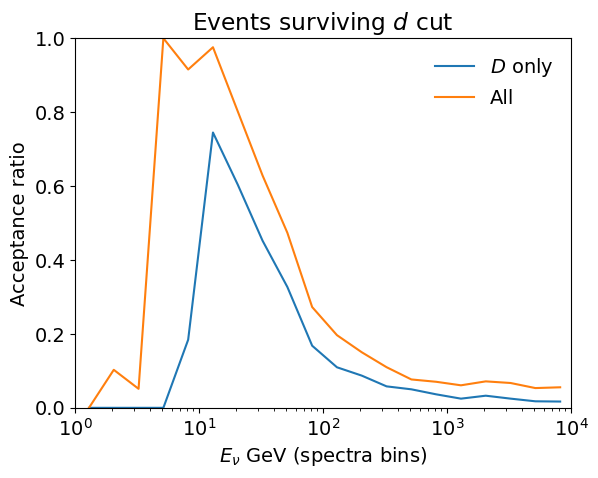

In [37]:
detector=detectors[0]  #Doesn't really matter which one is used, we look at P8 output statistics here
plot1D(datasets=[[ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',Donly=True, dMax=LdecMax,angleMax=-1.,NchCut=-1,Ebins=ecenters)],\
                 [ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',Donly=False,dMax=LdecMax,angleMax=-1.,NchCut=-1,Ebins=ecenters)]],\
       labels=[r'$D$ only',r'All'],\
       titles={'main':r'Events surviving $d$ cut', 'x':r'$E_\nu$ GeV (spectra bins)', 'y':r'Acceptance ratio'},\
       logs=[True,False],xlims=[1,1e4],ylims=[0,1],\
       savename='plots/'+proc+'_decay_length_cut_survival_ratio.pdf')

### Angular cut only

Saving image plots/dimuons_angular_cut_survival_ratio.pdf


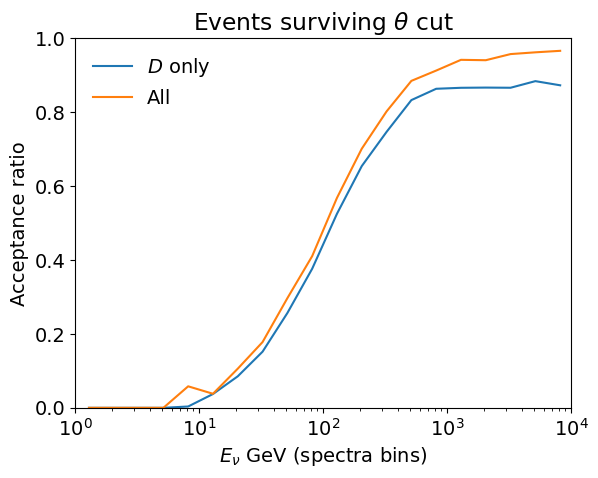

In [38]:
detector=detectors[0]  #Doesn't really matter which one is used, we look at P8 output statistics here
plot1D(datasets=[[ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',\
                                    Donly=True,dMax=-1., angleMax=thetaMax,NchCut=-1,Ebins=ecenters)],\
                 [ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',\
                                    Donly=False,dMax=-1.,angleMax=thetaMax,NchCut=-1,Ebins=ecenters)]],\
       labels=[r'$D$ only',r'All'],\
       titles={'main' : r'Events surviving $\theta$ cut',\
               'x'    : r'$E_\nu$ GeV (spectra bins)',\
               'y'    : r'Acceptance ratio'},\
       logs=[True,False],xlims=[1,1e4],ylims=[0,1],\
       savename='plots/'+proc+'_angular_cut_survival_ratio.pdf')

### Apply angular and decay length cuts

Saving image plots/dimuons_d_angular_cut_survival_ratio.pdf


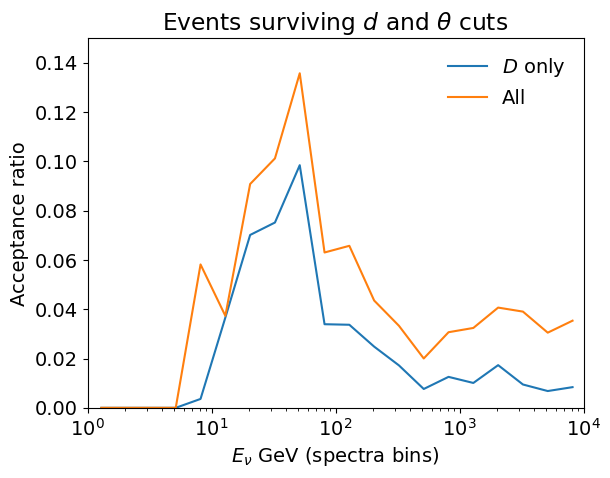

In [39]:
detector=detectors[0]  #Doesn't really matter which one is used, we look at P8 output statistics here
plot1D(datasets=[[ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',\
                                    Donly=True, dMax=LdecMax,angleMax=thetaMax,NchCut=-1,Ebins=ecenters)],\
                 [ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',\
                                    Donly=False,dMax=LdecMax,angleMax=thetaMax,NchCut=-1,Ebins=ecenters)]],\
       labels=[r'$D$ only',r'All'],\
       titles={'main' : r'Events surviving $d$ and $\theta$ cuts',\
               'x'    : r'$E_\nu$ GeV (spectra bins)',\
               'y'    : r'Acceptance ratio'},\
       logs=[True,False],xlims=[1,1e4],ylims=[0,0.15],\
       savename='plots/'+proc+'_d_angular_cut_survival_ratio.pdf')

### Charged track multiplicity cut

Saving image plots/dimuons_multiplicity_cut_survival_ratio.pdf


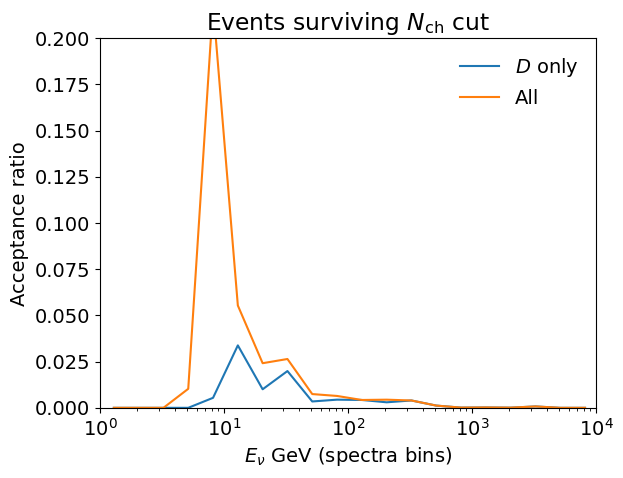

In [40]:
detector=detectors[0]  #Doesn't really matter which one is used, we look at P8 output statistics here
plot1D(datasets=[[ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',\
                                    Donly=True, dMax=-1,angleMax=-1,NchCut=NchMax,Ebins=ecenters)],\
                 [ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',\
                                    Donly=False,dMax=-1,angleMax=-1,NchCut=NchMax,Ebins=ecenters)]],\
       labels=[r'$D$ only',r'All'],\
       titles={'main' : r'Events surviving $N_{\rm ch}$ cut',\
               'x'    : r'$E_\nu$ GeV (spectra bins)',\
               'y'    : r'Acceptance ratio'},\
       logs=[True,False],xlims=[1,1e4],ylims=[0,0.2],\
       savename='plots/'+proc+'_multiplicity_cut_survival_ratio.pdf')

### Apply angle and multiplicity cuts

Saving image plots/dimuons_angle_multiplicity_cut_survival_ratio.pdf


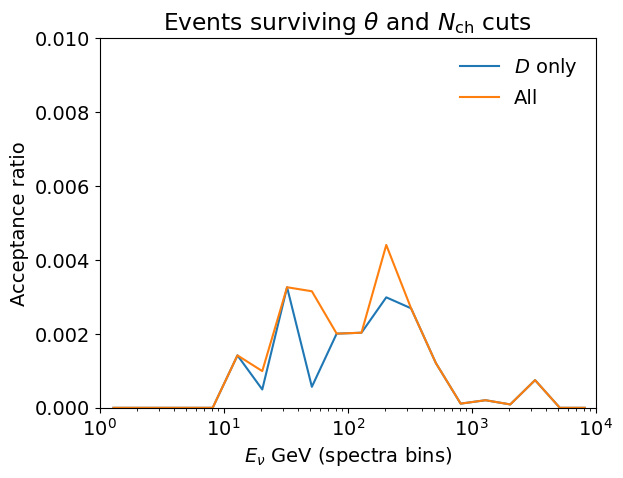

In [41]:
detector=detectors[0]  #Doesn't really matter which one is used, we look at P8 output statistics here
plot1D(datasets=[[ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',\
                                    Donly=True, dMax=-1,angleMax=thetaMax,NchCut=NchMax,Ebins=ecenters)],\
                 [ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',\
                                    Donly=False,dMax=-1,angleMax=thetaMax,NchCut=NchMax,Ebins=ecenters)]],\
       labels=[r'$D$ only',r'All'],\
       titles={'main' : r'Events surviving $\theta$ and $N_{\rm ch}$ cuts',\
               'x'    : r'$E_\nu$ GeV (spectra bins)',\
               'y'    : r'Acceptance ratio'},\
       logs=[True,False],xlims=[1,1e4],ylims=[0,0.01],\
       savename='plots/'+proc+'_angle_multiplicity_cut_survival_ratio.pdf')

### Apply all cuts

Saving image plots/dimuons_cut_survival_ratio.pdf


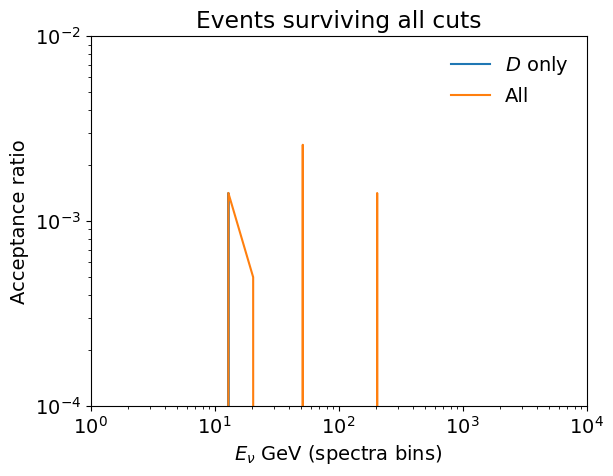

In [42]:
detector=detectors[0]  #Doesn't really matter which one is used, we look at P8 output statistics here
plot1D(datasets=[[ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',\
                                    Donly=True, dMax=LdecMax,angleMax=thetaMax,NchCut=NchMax,Ebins=ecenters)],\
                 [ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',\
                                    Donly=False,dMax=LdecMax,angleMax=thetaMax,NchCut=NchMax,Ebins=ecenters)]],\
       labels=[r'$D$ only',r'All'],\
       titles={'main' : 'Events surviving all cuts',\
               'x'    : r'$E_\nu$ GeV (spectra bins)',\
               'y'    : r'Acceptance ratio'},\
       logs=[True,True],xlims=[1,1e4],ylims=[1e-4,1e-2],\
       savename='plots/'+proc+'_cut_survival_ratio.pdf')

### Check events with 3 muons or more

Saving image plots/dimuons_plus_3_muons.pdf


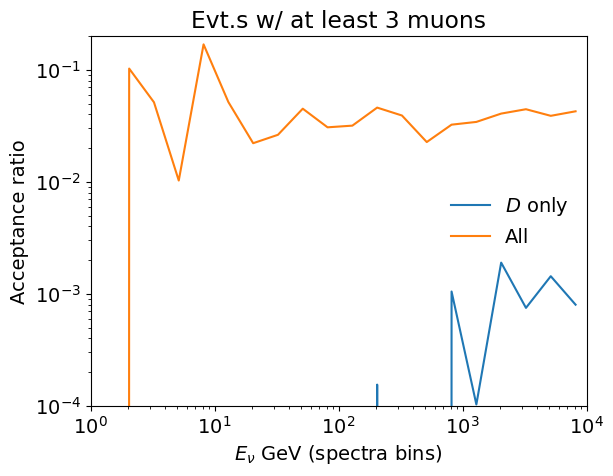

In [43]:
detector=detectors[0]  #Doesn't really matter which one is used, we look at P8 output statistics here
plot1D(datasets=[[ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',\
                                    Donly=True, dMax=-1,angleMax=-1,NchCut=-1,NmuMin=3,Ebins=ecenters)],\
                 [ecenters,findCuts(detector=detector,pred=genpairBLstr,proc=proc,vpidstr='14',\
                                    Donly=False,dMax=-1,angleMax=-1,NchCut=-1,NmuMin=3,Ebins=ecenters)]],\
       labels=[r'$D$ only',r'All'],\
       titles={'main' : 'Evt.s w/ at least 3 muons',\
               'x'    : r'$E_\nu$ GeV (spectra bins)',\
               'y'    : r'Acceptance ratio'},\
       logs=[True,True],xlims=[1,1e4],ylims=[1e-4,0.2],\
       savename='plots/'+proc+'_plus_3_muons.pdf')

### Hadron-specific plotstyle setup
Set up LaTeX strings and colors for 2nd muon parent hadrons

In [44]:
hadronstyles={}
hadronstyles['D+']           = [r'$D^+$'              , 'black'         ]
hadronstyles['D0']           = [r'$D^0$'              , 'dimgray'       ]
hadronstyles['D_s+']         = [r'$D_s^+$'            , 'darkgray'      ]
hadronstyles['D_s-']         = [r'$D_s^-$'            , 'rosybrown'     ]
hadronstyles['D-']           = [r'$D^-$'              , 'lightcoral'    ]
hadronstyles['omega']        = [r'$\omega$'           , 'firebrick'     ]
hadronstyles['Lambda0']      = [r'$\Lambda^0$'        , 'khaki'         ]
hadronstyles['Lambda_c+']    = [r'$\Lambda_c^+$'      , 'red'           ]
hadronstyles['eta']          = [r'$\eta$'             , 'sienna'        ]
hadronstyles['rho0']         = [r'$\rho^0$'           , 'chocolate'     ]
hadronstyles['mu+']          = [r'$\mu^+$'            , 'orange'        ]
hadronstyles['Sigma-']       = [r'$\Sigma^-$'         , 'gold'          ]
hadronstyles['tau+']         = [r'$\tau^+$'           , 'maroon'        ]
hadronstyles['mu-']          = [r'$\mu^-$'            , 'darkkhaki'     ]
hadronstyles["eta'"]         = [r"$\eta'$"            , 'olive'         ]
hadronstyles['Xi_c+']        = [r'$\Xi_c^+$'          , 'olivedrab'     ]
hadronstyles['Lambdabar0']   = [r'$\bar{\Lambda}^0$'  , 'yellowgreen'   ]
hadronstyles['Xi_c0']        = [r'$\Xi_c^0$'          , 'darkolivegreen']
hadronstyles['Sigmabar+']    = [r'$\bar{\Sigma}^+$'   , 'darkseagreen'  ]
hadronstyles['phi']          = [r'$\phi$'             , 'forestgreen'   ]
hadronstyles['Dbar0']        = [r'$\bar{D}^0$'        , 'turquoise'     ]
hadronstyles['Xibar+',]      = [r'$\bar{Xi}^+$'       , 'lightseagreen' ]
hadronstyles['Omega_c0']     = [r'$\Omega_c^0$'       , 'steelblue'     ]
hadronstyles['Xi-']          = [r'$\Xi^-$'            , 'dodgerblue'    ]
hadronstyles['tau-']         = [r'$\tau^-$'           , 'navy'          ]
hadronstyles['B-']           = [r'$B^-$'              , 'blue'          ]
hadronstyles['B0']           = [r'$B^0$'              , 'purple'        ]
hadronstyles['Bbar0']        = [r'$\bar{B}^0$'        , 'magenta'       ]
hadronstyles['Lambda_bbar0'] = [r'$\bar{\Lambda}_b^0$', 'violet'        ]
hadronstyles['Lambda_cbar-'] = [r'$\bar{\Lambda}_c^-$', 'cyan'          ]
hadronstyles['Xi_cbar0']     = [r'$\bar{\Xi}_c^0$'    , 'goldenrod'     ]
hadronstyles['B+']           = [r'$B^+$'              , 'deepskyblue'   ]
hadronstyles['B_sbar0']      = [r'$\bar{B}_s^0$'      , 'palegreen'     ]
hadronstyles['Xi_bbar0']     = [r'$\bar{\Xi}_b^0$'    , 'orchid'        ]
hadronstyles['Xibar+']       = [r'$\bar{\Xi}^+$'      , 'hotpink'       ]

## 2nd muon parent hadrons' decay length distribution
To estimate the decay lengths:
 - Take lifetimes from PDG, modulo application of a random probability about the mean value
 - Assume that the D moves _relativistically_ with the 4 momentum read from the file
 - See how far it travels w/in the given time

Charged and neutral parents are treated separately

In [45]:
#Plot b.g. illustrations only if experimental efficiencies not considered
if not useAcc:
    
    #Init
    Dch_d=[]
    D0_d=[]
    E_m2={}
    
    #Find D meson decay length distributions
    #d = \gamma\beta c\tau, where \gamma = E/m is the Lorentz factor, beta = v/c ~ 1, and \tau is meson lifetime
    #N.B. we account for the (small) difference in lifetime between neutral and charged D mesons (2nd muon parent)
    #     since they appear differently in emulsion
    studyE = 1000
    iE = iEfinder(studyE)  #Returns >=1 if found
    detector=detectors[0]  #Doesn't really matter which one is used, we look at P8 output statistics here
    #global mcbins  #TODO needed when moved inside a function
    fetchmcbins(genpairstr=genpairBLstr,detector=detector,inprocs=['dimuons'])
    tmp = mcbins['dimuons']['14'][str(iE)]
    for i in range(len(tmp['x'])):
        #Ensure 2nd muon w/ momentum > 0 exists
        if tmp['E_2' ][i]==0 and tmp['px_2'][i]==0 and tmp['py_2'][i]==0 and tmp['pz_2'][i]==0:
            continue        
        name2m = tmp['name_2m'][i]  #Abbreviation for the name of 2nd muon parent hadron
        if name2m in Dmesons:
            d = decayLength(name=name2m,px=tmp['px_2m'][i],py=tmp['py_2m'][i],pz=tmp['pz_2m'][i])
            if d<0.:
                print('WARNING: cannot compute decay length, skipping')
                continue
            if name2m in Dch:
                Dch_d.append(d)
            elif name2m in Dnt:  
                D0_d.append(d)
        if name2m not in list(E_m2.keys()): E_m2[name2m]=[] 
        E_m2[name2m].append(tmp['E_2m'][i])
    
    #Plot decay length histo(s) with linear vertical axis
    #Weigh by the total number of all D mesons (i.e. assuming they constitute most of the sample)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0.16, 0.12, 0.82, 0.82])
    bins_Dch_d  = np.linspace(0,0.15,30)
    plotTest(plt.hist(Dch_d,bins=bins_Dch_d,\
                      weights=np.multiply(1.0/(len(Dch_d)+len(D0_d)),np.ones(len(Dch_d))),\
                      color='gray', label=r', '.join(DchLtX)),\
             testsubdir = 'dimuons-tridents',\
             testtag = codename+'_Dch_d',\
             mode = 'histo')
    plotTest(plt.hist(D0_d, bins=bins_Dch_d,\
                      weights=np.multiply(1.0/(len(Dch_d)+sum(D0_d)),np.ones(len(D0_d))),\
                      color='maroon',alpha=0.5,label=r', '.join(DntLtX)),\
             testsubdir = 'dimuons-tridents',\
             testtag = codename+'_D0_d',\
             mode = 'histo')
    
    plt.title(r'$E_\nu=$'+str(int(studyE))+' GeV')
    plt.xlabel(r'Decay length [m]')
    plt.ylabel(r'Event weight')
    matplotlib.rcParams.update({'legend.fontsize': 'small'})
    matplotlib.rcParams.update({'legend.loc':'upper right'})
    matplotlib.rcParams.update({'legend.frameon':False})
    plt.legend()
    savename='plots/D_decay_lengths_linear_'+str(int(studyE))+'.pdf'
    print('Saving image '+savename)
    plt.savefig(savename)
    plt.show()
    plt.clf()
    
    #Plot decay length histo(s) with linear vertical axis, zoom in
    #Weigh by the total number of all D mesons (i.e. assuming they constitute most of the sample)
    bins_Dch_d  = np.linspace(0,2e-2,30)
    plt.hist(Dch_d,bins=bins_Dch_d,\
             weights=np.multiply(1.0/(len(Dch_d)+len(D0_d)),np.ones(len(Dch_d))),\
             color='gray', label=r', '.join(DchLtX))
    plt.hist(D0_d, bins=bins_Dch_d,\
             weights=np.multiply(1.0/(len(Dch_d)+len(D0_d)),np.ones(len(D0_d))),\
             color='maroon', alpha=0.5,label=r', '.join(DntLtX))
    plt.title(r'$E_\nu=$'+str(int(studyE))+' GeV')
    plt.xlabel(r'Decay length [m]')
    plt.ylabel(r'Event weight')
    matplotlib.rcParams.update({'legend.fontsize': 'small'})
    matplotlib.rcParams.update({'legend.loc':'upper right'})
    matplotlib.rcParams.update({'legend.frameon':False})
    plt.legend()
    savename='plots/D_decay_lengths_linear_zoom_'+str(int(studyE))+'.pdf'
    print('Saving image '+savename)
    plt.savefig(savename)
    plt.show()
    plt.clf()
    
    #Plot parent hadron energy histos
    plt.tight_layout()
    if len(list(E_m2.keys())) > len(list(hadronstyles.keys())):
        print('ERROR: you need to specify '+str(len(list(E_m2.keys()))-len(list(hadronstyles.keys())))+' more colors')
    intall = 0.0
    binsEhad = np.linspace(0,studyE,50)
    #Find normalization factor: fraction of all evt.s
    for m2name in list(E_m2.keys()):
        h = plt.hist(E_m2[m2name],bins=binsEhad)
        intall += sum(h[0])
    #Plot normalized histos
    plt.clf()
    for m2name in list(E_m2.keys()):
        h = plt.hist(E_m2[m2name],bins=binsEhad,weights=np.multiply(1.0/intall,np.ones(len(E_m2[m2name]))),\
                     color=hadronstyles[m2name][1],label=hadronstyles[m2name][0],histtype='step')
        plotTest(h,testsubdir = 'dimuons-tridents',testtag = codename+'_parent_hadron_E_'+m2name,mode = 'histo')
    plt.title(r'$E_\nu=$'+str(int(studyE))+' GeV')
    plt.xlabel(r'Meson energy [GeV]')
    plt.ylabel(r'Event weight')
    plt.yscale('log')
    plt.ylim(1e-4,7e-2)
    matplotlib.rcParams.update({'legend.fontsize': 'x-small'})
    plt.legend(ncol=5,frameon=False)
    savename='plots/E_2nd_muon_parents_'+str(int(studyE))+'.pdf'
    print('Saving image '+savename)
    plt.savefig(savename)
    plt.show()
    plt.clf()

### Plots of 1st and 2nd muon-related quantities at a fixed energy

In [46]:
def plotSingleE(detector,studyE,nuid,procs):
    
    #Style setup
    matplotlib.rcParams.update({'font.size': 14})
    matplotlib.rcParams.update({'legend.fontsize': 'medium'})
    matplotlib.rcParams.update({'axes.labelsize': 'large'})
    matplotlib.rcParams.update({'axes.titlesize':'large'})
    matplotlib.rcParams.update({'xtick.labelsize':'large'})
    matplotlib.rcParams.update({'ytick.labelsize':'large'})
 
    #Find index corresponding to interesting neutrino energy
    iE=iEfinder(studyE)  #Returns >=1 if found
            
       
    #Init
    E1={}
    p1={}
    E2={}
    p2={}
    wgt={}
    wgtNch={}
    global mcbins
    fetchmcbins(genpairstr=genpairBLstr,detector=detector,inprocs=procs)

    bins_E1 = np.linspace(0,studyE,25)
    bins_E2 = np.linspace(0,studyE,25)

    for proc in procs:
        E1[proc]=[]
        p1[proc]=[]
        E2[proc]=[]
        p2[proc]=[]
        wgt[proc]=[]
        if not mcbins[proc][nuid][str(iE)]['empty']:
            for i in range(len(  mcbins[proc][nuid][str(iE)]['E_1'])):
                E1[proc].append( mcbins[proc][nuid][str(iE)]['E_1' ][i])
                p1[proc].append([mcbins[proc][nuid][str(iE)]['px_1'][i],\
                                 mcbins[proc][nuid][str(iE)]['py_1'][i],\
                                 mcbins[proc][nuid][str(iE)]['pz_1'][i]])
                E2[proc].append( mcbins[proc][nuid][str(iE)]['E_2' ][i])
                p2[proc].append([mcbins[proc][nuid][str(iE)]['px_2'][i],\
                                 mcbins[proc][nuid][str(iE)]['py_2'][i],\
                                 mcbins[proc][nuid][str(iE)]['pz_2'][i]])
                wgt[proc].append(mcbins[proc][nuid][str(iE)]['spectrawgt'][i])
    
        #Heatmap of the corresponding mu- and mu+ energies -- arbitrary units for height/temp.
        plt.hist2d(E1[proc],E2[proc],bins=[bins_E1,bins_E2],weights=wgt[proc],rasterized=True)
        plt.title(r'$E_\nu = $'+str(studyE)+r' GeV, '+proc)
        plt.xlabel(r'$E_{\mu^-}$ [GeV]')
        plt.ylabel(r'$E_{\mu^+}$ [GeV]')
        savename='plots/'+proc+'_E_mup_vs_mum_heatmap_'+proc+'_'+str(int(studyE))+'_GeV.pdf'
        print('Saving image '+savename)
        plt.savefig(savename)
        plt.show()
        
        #Muon energy ratio -- histos not normalized by bin width, only by expected #evt.s
        #Adding all columns together then reproduces the #events at a given E
        plt.clf()
        EmuRatio = np.divide(E2[proc],E1[proc])
        h = plt.hist(EmuRatio,bins=np.linspace(0,1,20)) #Unwgt'd histo's integral...
        plt.clf()  #Do not plot unwgt'd histo
        integral = sum(h[0])                            #...for later normalization
        normto1 = np.multiply(1.0/integral,np.ones(len(EmuRatio)))  #Norm. to 1
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_axes([0.16, 0.12, 0.82, 0.82], xticklabels=[], )
        h = plt.hist(EmuRatio,bins=np.linspace(0,1,20),weights=normto1)
        plotTest(h,testsubdir = 'dimuons-tridents',
                 testtag = codename+'_plotSingleE_'+detector+'_'+str(int(studyE))+'_'+str(nuid)+'_'+proc,\
                 mode = 'histo')

        integral = sum(h[0])
        print('Integral of muon energy ratio histo: '+str(integral))
        plt.title(r'$E_\nu = $'+str(studyE)+r' GeV')
        plt.xlabel(r'$E_{\mu^+}/E_{\mu^-}$')
        plt.ylabel(r'Event weight')
        savename = 'plots/'+proc+'_E_mu_ratio_'+proc+'_'+str(int(studyE))+'.pdf'
        print('Saving image '+savename)
        plt.savefig(savename)
        plt.show()
        #Muon energy ratio zoom -- same normto1 weight as above
        h = plt.hist(EmuRatio,bins=np.linspace(0,0.04,30))
        plt.clf()
        normto1 = np.multiply(1.0/sum(h[0]),np.ones(len(EmuRatio)))
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_axes([0.16, 0.12, 0.82, 0.82], xticklabels=[], )
        h = plt.hist(EmuRatio,bins=np.linspace(0,0.04,30),weights=normto1)
        plotTest(h,\
                 testsubdir = 'dimuons-tridents',\
                 testtag = codename+'_plotSingleE_EmuRatio_'+detector+'_'+str(int(studyE))+'_'+str(nuid)+'_'+proc,\
                 mode = 'histo')
        
        titleproc = 'background' if proc=='dimuons' else proc
        plt.title(r'$E_\nu = $'+str(studyE)+r' GeV, '+titleproc)
        plt.xlabel(r'$E_{\mu^+}/E_{\mu^-}$')
        plt.ylabel(r'Event weight')
        savename = 'plots/'+proc+'_E_mu_ratio_zoom_'+proc+'_'+str(int(studyE))+'.pdf'
        print('Saving image '+savename)
        plt.savefig(savename)
        plt.show()
        
    #Angle between muons
    plt.clf()
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0.16, 0.12, 0.82, 0.82], xticklabels=[], )
    anglebins = np.logspace(np.log10(0.005),np.log10(math.pi),50)
    sty={}
    sty['dimuons'] =['lightseagreen',  1.0,'Background']
    sty['tridents']=['purple',0.5,'Tridents']
    for proc in procs:
        p1mag = np.array( list( map(np.sqrt,[np.dot(p,p) for p in p1[proc]]) ) )
        p2mag = np.array( list( map(np.sqrt,[np.dot(p,p) for p in p2[proc]]) ) )
        p1p2dots = [np.dot(p2[proc][i],p1[proc][i]) for i in range(len(p1[proc]))]
        angles = np.array(list(map(np.arccos,np.divide(p1p2dots,np.multiply(p1mag,p2mag)))))
        h = plt.hist(angles,bins=anglebins,\
                     weights=wgt[proc],\
                     histtype='bar',color=sty[proc][0],alpha=sty[proc][1],label=sty[proc][2])
        plotTest(h,testsubdir = 'dimuons-tridents',\
                 testtag=codename+'_plotSingleE_muon_angle_'+detector+'_'+str(int(studyE))+'_'+str(nuid)+'_'+proc,\
                 mode = 'histo')
        print('Integral of '+proc+' muon angle histo: '+str(sum(h[0])))
    plt.title(r'$E_\nu = $'+str(studyE)+r' GeV')
    plt.xlabel(r'$\angle(E_{\mu^+},E_{\mu^-}) [rad]$')
    plt.ylabel(r'$N$')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(frameon=False)
    savename = 'plots/'+'_'.join(procs)+'_muon_angle_'+str(int(studyE))+'.pdf'
    print('Saving image '+savename)
    plt.savefig(savename)
    plt.show()


In [47]:
#Plot b.g. illustrations only if experimental efficiencies not considered
if not useAcc:
    plotSingleE(detector=detectors[0],studyE=1000.0,nuid='14',procs=['dimuons','tridents'])

### Low- vs high-energy muon energy distributions
First, fetch relevant vectors from `mcbins` object. 
Then sum over all neutrino energy bins and weigh according to baseline spectra.

In [48]:
def E_mup_vs_mum(detector,genpairstr,acctable):
       
    #Style setup
    matplotlib.rcParams.update({'font.size': 14})
    matplotlib.rcParams.update({'legend.fontsize': 'medium'})
    matplotlib.rcParams.update({'axes.labelsize': 'large'})
    matplotlib.rcParams.update({'axes.titlesize':'large'})
    matplotlib.rcParams.update({'xtick.labelsize':'large'})
    matplotlib.rcParams.update({'ytick.labelsize':'large'})
    
    #Init
    proc='tridents'
    global mcbins
    fetchmcbins(genpairstr=genpairstr,detector=detector,inprocs=[proc])
    accIP = acctableIP(acctable)
    Ehi=[]
    Elo=[]
    wgt=[]
    efflo=[]
    effhi=[]

    #Fetch Ehi, Elo, wgt from mcbins
    for vpidstr in vpidstrs:
        for iEkey in list(mcbins[proc][vpidstr].keys()): 
            if not mcbins[proc][vpidstr][iEkey]['empty']:
                tmp = mcbins[proc][vpidstr][iEkey]
                Emax = np.maximum(tmp['E_1'],tmp['E_2'])
                Emin = np.minimum(tmp['E_1'],tmp['E_2'])
                Ehi.append(Emax)
                Elo.append(Emin)
                wgt.append(tmp['spectrawgt'])
                efflo.append(accIP(Emin)*tmp['spectrawgt'])
                effhi.append(accIP(Emax)*tmp['spectrawgt'])
    Ehi = np.array(Ehi).flatten()
    Elo = np.array(Elo).flatten()
    wgt = np.array(wgt).flatten()
    efflo = np.array(efflo).flatten()
    effhi = np.array(effhi).flatten()
    
    print('Ehi=',Ehi)
    print('wgt=',wgt)
    
    #Now, plot $\mu^-$ and $\mu^+$ energy distributions from the data gathered above.
    proc='tridents'
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_axes([0.14, 0.14, 0.82, 0.83], )
    bins_E = np.logspace(0,np.log10(5000),50)
    plotTest(plt.hist(Ehi, bins=bins_E, weights=wgt,\
                      color='gray',histtype='step'),\
             testsubdir = 'dimuons-tridents',\
             testtag = codename+'_Ehi_mup_vs_mum_'+detector+'_'+genpairstr+'_'+proc,\
             mode = 'histo')
    plotTest(plt.hist(Elo, bins=bins_E, weights=wgt,\
                      color='maroon', histtype='step', alpha=0.5),\
             testsubdir = 'dimuons-tridents',\
             testtag = codename+'_Elo_mup_vs_mum_'+detector+'_'+genpairstr+'_'+proc,\
             mode = 'histo')
    #Add plots with efficiency applied
    plotTest(plt.hist(Ehi, bins=bins_E, weights=effhi, label=r'High-$E$ $\mu$',color='gray'),\
             testsubdir = 'dimuons-tridents',\
             testtag = codename+'_Ehi_mup_vs_mum_ef_'+detector+'_'+genpairstr+'_'+proc,\
             mode = 'histo')
    plotTest(plt.hist(Elo, bins=bins_E, weights=efflo, label=r'Low-$E$ $\mu$', color='maroon', alpha=0.5),\
             testsubdir = 'dimuons-tridents',\
             testtag = codename+'_Elo_mup_vs_mum_ef_'+detector+'_'+genpairstr+'_'+proc,\
             mode = 'histo')
    
    plt.xlabel(r'$E_\mu$ [GeV]')
    plt.ylabel(r'$N$')
    plt.legend(frameon=False,loc='upper left')
    plt.xscale('log')
    plt.xlim(1,5000)
    savename='plots/'+proc+'_E_mup_vs_mum.pdf'
    print('Saving image '+savename)
    plt.savefig(savename)
    plt.show()                    

In [49]:
if not useAcc and 'FASERv2' in detectors:
    E_mup_vs_mum(detector='FASERv2',genpairstr=genpairBLstr,acctable=acctable)

## Plot the effects of various cuts on the spectra
Optionally, this can be plotted for all neutrinos or only those originating from D-mesons (most important contribution, functionality left for reference/quick checks).
Note that the same function for finding the cuts takes care of excluding non-D-meson-associated neutrino events

In [73]:
def plotSpectraCuts(detector,Donly,genpair):
        
    genpairstr = '&'.join(list(genpair.values()))
    global codename
    filename = 'plots/'+codename
    if Donly: filename += '_Donly'
    filename += '_' + detector + '_' + genpairstr
    filename += '_1_radial_bin_bg_cuts.pdf'
    
    #Setup figure
    matplotlib.rcParams.update({'font.size': 14})
    matplotlib.rcParams.update({'legend.fontsize': 'medium'})
    matplotlib.rcParams.update({'axes.labelsize': 'large'})
    matplotlib.rcParams.update({'axes.titlesize':'large'})
    matplotlib.rcParams.update({'xtick.labelsize':'large'})
    matplotlib.rcParams.update({'ytick.labelsize':'large'})
    matplotlib.rcParams['text.usetex'] = False
    fig = plt.figure(figsize=(4.7,6))
    ax11 = fig.add_axes([0.21, 0.12, 0.77, 0.83], )
    axes = np.array([[ax11]])
    
    #Extract bin information
    baseline1 = model(detector=detector, radN='_rad1', lambdamat=genPairLambdaMatrix(genpair))
    ebins = np.array(baseline1['14']['ebins'])
    ecenters = (ebins[1:]+ebins[:-1])/2
    
    #Ratios of entries surviving various cuts
    cutWgt_a   = findCuts(detector=detector,pred=genpairstr,proc='dimuons', vpidstr='14',Donly=Donly,dMax=-1,     angleMax=thetaMax,              Ebins=ecenters)
    cutWgt_d   = findCuts(detector=detector,pred=genpairstr,proc='dimuons', vpidstr='14',Donly=Donly,dMax=LdecMax,angleMax=-1,                    Ebins=ecenters)
    cutWgt_a_d = findCuts(detector=detector,pred=genpairstr,proc='dimuons', vpidstr='14',Donly=Donly,dMax=LdecMax,angleMax=thetaMax,              Ebins=ecenters)
    cutWgt_m   = findCuts(detector=detector,pred=genpairstr,proc='dimuons', vpidstr='14',Donly=Donly,dMax=-1,     angleMax=-1,      NchCut=NchMax,Ebins=ecenters)
    cutWgt_a_m = findCuts(detector=detector,pred=genpairstr,proc='dimuons', vpidstr='14',Donly=Donly,dMax=-1,     angleMax=thetaMax,NchCut=NchMax,Ebins=ecenters)
    cutWgt_d_m = findCuts(detector=detector,pred=genpairstr,proc='dimuons', vpidstr='14',Donly=Donly,dMax=LdecMax,angleMax=-1,      NchCut=NchMax,Ebins=ecenters)
    cutWgt_tri = findCuts(detector=detector,pred=genpairstr,proc='tridents',vpidstr='14',            dMax=LdecMax,angleMax=thetaMax,              Ebins=ecenters)
    #For general case, also write a log of bg evts passing all cuts. Not written for D-only case.
    if not Donly:
        cutWgt_a_d_m = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,dMax=LdecMax,angleMax=thetaMax,NchCut=NchMax,Ebins=ecenters,\
                                logname='bg_evts_passing_all_cuts.txt')
    else:
        cutWgt_a_d_m = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,dMax=LdecMax,angleMax=thetaMax,NchCut=NchMax,Ebins=ecenters)
    
    nmax = 1
    dimuon_entries1  = np.array(baseline1['14']['n_int_dimuons']).T[0]
    trident_entries1 = np.array(baseline1['14']['n_int_tridents']).T[0]
    if max(dimuon_entries1)>nmax: nmax=max(dimuon_entries1)
    
    bgstyle='dotted'
    Dlabel = r''
    if Donly: Dlabel = r'D only, '
    
    col='black'
    axes[0,0].hist(x=ecenters, weights=dimuon_entries1, bins=ebins,\
                   histtype='step', color=col, ls=bgstyle, lw=1.5)
    axes[0,0].text(30, 30, 'All DIS b.g.', color=col, rotation=55.)
    
    col='teal'
    axes[0,0].hist(x=ecenters, weights=np.multiply(cutWgt_a,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls=bgstyle, lw=1.5)
    axes[0,0].text(200, 100, Dlabel + r'$\theta$ cut', color=col, rotation=40.)
    
    col='brown'
    axes[0,0].hist(x=ecenters, weights=np.multiply(cutWgt_d,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col, ls=bgstyle, lw=1.5)
    axes[0,0].text(110, 30, Dlabel + r'$d$ cut', color=col, rotation=32.)

    #col='dodgerblue'
    #axes[0,0].hist(x=ecenters, weights=np.multiply(cutWgt_a_d,dimuon_entries1), bins=ebins,\
    #               histtype='step', color=col, ls=bgstyle, lw=1.5)
    #axes[0,0].text(40, 4, Dlabel + r'$\theta$ & $d$ cuts', color=col, rotation=30.)
    
    col='orange'
    axes[0,0].hist(x=ecenters, weights=np.multiply(cutWgt_m,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col, ls=bgstyle, lw=1.5)
    axes[0,0].text(50, 0.3, Dlabel + r'$N_{ch}$ cut', color=col, rotation=45.)
    
    #col='maroon'
    #axes[0,0].hist(x=ecenters, weights=np.multiply(cutWgt_a_m,dimuon_entries1), bins=ebins,\
    #               histtype='step', color=col, ls=bgstyle, lw=1.5)
    #axes[0,0].text(40, 0.2, Dlabel + r'$\theta$ & $N_{ch}$ cut', color=col, rotation=30.)
    
    col='purple'
    axes[0,0].hist(x=ecenters, weights=np.multiply(cutWgt_a_d_m,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col, ls=bgstyle, lw=1.5)
    if Donly: axes[0,0].text(70, 0.13, Dlabel + 'all cuts$\downarrow$', color=col, rotation=0.)
    else:  axes[0,0].text(160, 0.13, 'All cuts', color=col, rotation=0.)
    
    col='crimson'
    axes[0,0].hist(x=ecenters, weights=trident_entries1, bins=ebins,\
                   histtype='step', color=col, ls='solid', lw=1.5)
    axes[0,0].hist(x=ecenters, weights=np.multiply(cutWgt_tri, trident_entries1), bins=ebins,\
                   histtype='step', color=col, ls='dashed', lw=1.5)
    axes[0,0].text(300, 3, r'Signal', color=col, rotation=0.)
    
    axes[0,0].plot([],[],color='black',ls=bgstyle,lw=1.2,label='Background')
    axes[0,0].plot([],[],color='black',ls='solid',lw=1.2,label='Signal, no cuts')
    axes[0,0].plot([],[],color='black',ls='dashed',lw=1.2,label='Signal, cuts')
    
    #Check number of events
    nnus  = baseline1['14']['n_nu'].flatten()
    nints = baseline1['14']['n_int_dimuons'].flatten()
    print('For nu id 14 (sum w/ -14)')
    print('  Total #neutrinos = ',sum(nnus))    
    print('  Total #interactions = ',sum(nints))    
    print('  #int.act. surviving decay length cut = ',sum(np.multiply(cutWgt_d,nints)))    
    print('  #int.act. surviving angular cut = ',sum(np.multiply(cutWgt_a,nints)))    
    print('  #int.act. surviving multiplicity cut = ',sum(np.multiply(cutWgt_m,nints)))    
    print('  #int.act. surviving decay length and multiplicity cuts = ',sum(np.multiply(cutWgt_d_m,nints)))    
    print('  #int.act. surviving all cuts = ',sum(np.multiply(cutWgt_a_d_m,nints)))    
    
    #Plotstyle setup
    axes[0,0].set_ylabel("Interacting neutrinos")
    axes[0,0].set_xlabel(r'$E_\nu$ [GeV]')
    axes[0,0].set_xscale("log")
    axes[0,0].set_yscale("log")
    axes[0,0].set_xlim(10,5000)
    axes[0,0].set_ylim(1e-1,nmax*2.2)
    detectorstr = detector.replace('FASERv',r'FASER$\nu$')
    axes[0,0].set_title(genpairstr + r', ' + detectorstr)
    matplotlib.rcParams.update({'legend.loc':'upper left'})
    axes[0,0].legend(frameon=False)
    
    #Save plot
    if filename is not None: 
        plt.savefig(filename)
        print('Saved ',filename)
    plt.show()

In [74]:
##Plot b.g. illustrations, restrict to D-meson-neutrinos only
#plotSpectraCuts(detector=detectors[0], Donly=True, genpair=genpairBL)

Dimuon file empty at iE = 1
Dimuon file empty at iE = 2
Dimuon file empty at iE = 3
Dimuon file empty at iE = 4
Dimuon file empty at iE = 6
Read MC bins for FASERv2, EPOSLHC&BKRS
Read MC bins for FASERv2, EPOSLHC&BKRS
Dimuon file empty at iE = 1
Dimuon file empty at iE = 2
Dimuon file empty at iE = 3
Dimuon file empty at iE = 4
Dimuon file empty at iE = 6
Read MC bins for FASERv2, EPOSLHC&BKRS
For nu id 14 (sum w/ -14)
  Total #neutrinos =  20380567955415.11
  Total #interactions =  3988.5190556483967
  #int.act. surviving decay length cut =  338.77822548731064
  #int.act. surviving angular cut =  3511.3277470928965
  #int.act. surviving multiplicity cut =  4.981791391280982
  #int.act. surviving decay length and multiplicity cuts =  1.2667714520861924
  #int.act. surviving all cuts =  0.3518272862198497
Saved  plots/cSBBB_lSQEE_acc_FASERv2_EPOSLHC&BKRS_1_radial_bin_bg_cuts.pdf


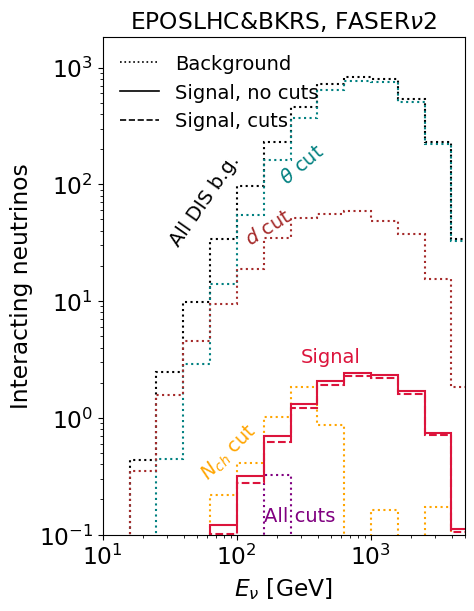

In [75]:
#Same as above but do not restrict b.g. to D-only case
plotSpectraCuts(detector=detectors[0], Donly=False, genpair=genpairBL)

### Investigate different initial quarks' contributions

In [53]:
def plotQuarkContributions(detector,Donly,genpair):
    
    genpairstr = '&'.join(list(genpair.values()))
    filename = 'plots/'+codename
    if Donly: filename += '_Donly'
    filename += '_1_radial_bin_bg_quark_contributions.pdf'
    
    #Setup figure
    matplotlib.rcParams.update({'font.size': 14})
    matplotlib.rcParams.update({'legend.fontsize': 'medium'})
    matplotlib.rcParams.update({'axes.labelsize': 'large'})
    matplotlib.rcParams.update({'axes.titlesize':'large'})
    matplotlib.rcParams.update({'xtick.labelsize':'large'})
    matplotlib.rcParams.update({'ytick.labelsize':'large'})
    matplotlib.rcParams['text.usetex'] = False
    fig = plt.figure(figsize=(4.7,6))
    ax11 = fig.add_axes([0.21, 0.12, 0.77, 0.83], )
    axes = np.array([[ax11]])
    
    #Extract information from baseline
    baseline1 = model(detector=detector,radN='_rad1',lambdamat=genPairLambdaMatrix(genpair))    
    ebins = np.array(baseline1['14']['ebins'])
    ecenters = (ebins[1:]+ebins[:-1])/2
    #Fractions of particular quarks' contributions to the spectrum
    s_only             = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,\
                                  dMax=-1,     angleMax=-1,      Ebins=ecenters,quarks=['s'])
    ubar_only          = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,\
                                  dMax=-1,     angleMax=-1,      Ebins=ecenters,quarks=['ubar'])
    d_only             = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,\
                                  dMax=-1,     angleMax=-1,      Ebins=ecenters,quarks=['d'])
    #Fractions of entries surviving angular and decay length cuts
    s_only_a_d_cuts    = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,\
                                  dMax=LdecMax,angleMax=thetaMax,Ebins=ecenters,quarks=['s'])
    ubar_only_a_d_cuts = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,\
                                  dMax=LdecMax,angleMax=thetaMax,Ebins=ecenters,quarks=['ubar'])
    d_only_a_d_cuts    = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,\
                                  dMax=LdecMax,angleMax=thetaMax,Ebins=ecenters,quarks=['d'])
    #Fractions of entries surviving charged track multiplicity cut
    s_only_Nch_cut     = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,\
                                  dMax=-1,angleMax=-1,NchCut=NchMax,Ebins=ecenters,quarks=['s'])
    ubar_only_Nch_cut  = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,\
                                  dMax=-1,angleMax=-1,NchCut=NchMax,Ebins=ecenters,quarks=['ubar'])
    d_only_Nch_cut     = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,\
                                  dMax=-1,angleMax=-1,NchCut=NchMax,Ebins=ecenters,quarks=['d'])
    #Fractions of entries surviving angular and decay length cuts
    s_only_all_cuts    = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,\
                                  dMax=LdecMax,angleMax=thetaMax,NchCut=NchMax,Ebins=ecenters,quarks=['s'])
    ubar_only_all_cuts = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,\
                                  dMax=LdecMax,angleMax=thetaMax,NchCut=NchMax,Ebins=ecenters,quarks=['ubar'])
    d_only_all_cuts    = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',Donly=Donly,\
                                  dMax=LdecMax,angleMax=thetaMax,NchCut=NchMax,Ebins=ecenters,quarks=['d'])
    nmax = 1
    dimuon_entries1  = np.array(baseline1['14']['n_int_dimuons']).T[0]
    trident_entries1 = np.array(baseline1['14']['n_int_tridents']).T[0]
    if max(dimuon_entries1)>nmax: nmax=max(dimuon_entries1)
    
    col='black'
    axes[0,0].hist(x=ecenters, weights=dimuon_entries1, bins=ebins,\
                   histtype='step', color=col, ls='solid', lw=1.0, label="All b.g. events")
    
    col='teal'
    axes[0,0].hist(x=ecenters, weights=np.multiply(s_only,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls='solid', lw=1.0, label=r'$s$ only')
    
    col='maroon'
    axes[0,0].hist(x=ecenters, weights=np.multiply(ubar_only,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls='solid', lw=1.0, label=r'$\bar{u}$ only')
    axes[0,0].hist(x=ecenters, weights=np.multiply(ubar_only_a_d_cuts,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls='dashed', lw=1.0, label=r'$\bar{u}$ only, $\theta$ & $d$ cuts')
    axes[0,0].hist(x=ecenters, weights=np.multiply(ubar_only_Nch_cut,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls='dotted', lw=1.5,\
                   label=r'$\bar{u}$ only, $N_{\rm ch}='+str(NchMax)+'$ cut')
    
    col='dodgerblue'
    axes[0,0].hist(x=ecenters, weights=np.multiply(d_only,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls='solid', lw=1.0, label=r'$d$ only')
    axes[0,0].hist(x=ecenters, weights=np.multiply(d_only_a_d_cuts,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls='dashed', lw=1.0, label=r'$d$ only, $\theta$ & $d$ cuts')
    axes[0,0].hist(x=ecenters, weights=np.multiply(d_only_Nch_cut,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls='dotted', lw=1.5,\
                   label=r'$d$ only, $N_{\rm ch}='+str(NchMax)+'$ cut')
    
    #col='gray'
    #axes[0,0].hist(x=ecenters, weights=np.multiply(ud_only,dimuon_entries1), bins=ebins,\
    #               histtype='step', color=col,  ls='dotted', lw=1.5, label=r'$u$ and $d$ only')
    
    
    #Check number of events
    nnus  = baseline1['14']['n_nu'].flatten()
    nints = baseline1['14']['n_int_dimuons'].flatten()
    Donlystr=''
    if Donly: Donlystr=' (D only)'
    print('For nu id 14')
    print('  Total #neutrinos = ',sum(nnus))    
    print('  Total #interactions = ',sum(nints))
    print('Before cuts'+Donlystr+':')
    print('  #s    only events = ',sum(np.multiply(s_only,    nints)))    
    print('  #ubar only events = ',sum(np.multiply(ubar_only, nints)))    
    print('  #d    only events = ',sum(np.multiply(d_only,    nints)))    
    print('Surviving angular and decay length cuts'+Donlystr+':')
    print('  #s    only events = ',sum(np.multiply(s_only_a_d_cuts,    nints)))    
    print('  #ubar only events = ',sum(np.multiply(ubar_only_a_d_cuts, nints)))    
    print('  #d    only events = ',sum(np.multiply(d_only_a_d_cuts,    nints)))    
    print('Surviving multiplicity cut'+Donlystr+':')
    print('  #s    only events = ',sum(np.multiply(s_only_Nch_cut,    nints)))    
    print('  #ubar only events = ',sum(np.multiply(ubar_only_Nch_cut, nints)))    
    print('  #d    only events = ',sum(np.multiply(d_only_Nch_cut,    nints)))    
    print('Surviving all cuts'+Donlystr+':')
    print('  #s    only events = ',sum(np.multiply(s_only_all_cuts,    nints)))    
    print('  #ubar only events = ',sum(np.multiply(ubar_only_all_cuts, nints)))    
    print('  #d    only events = ',sum(np.multiply(d_only_all_cuts,    nints)))    
        
    #Plotstyle setup
    axes[0,0].set_ylabel('Interacting neutrinos at '+detector)
    axes[0,0].set_xlabel(r'$E_\nu$ [GeV]')
    axes[0,0].set_xscale("log")
    axes[0,0].set_yscale("log")
    axes[0,0].set_xlim(10,5000)
    axes[0,0].set_ylim(1e-1,nmax*2.2)
    axes[0,0].set_title(genpairstr+Donlystr)
    matplotlib.rcParams.update({'legend.loc':'upper left'})
    axes[0,0].legend(frameon=False)
    
    #finalize figure
    if filename is not None: 
        plt.savefig(filename)
        print('Saved ',filename)
    plt.show()

In [54]:
#Plot b.g. illustrations only if experimental efficiencies not considered
if not useAcc:
    plotQuarkContributions(detector=detectors[0],Donly=True,genpair=genpairBL)

In [55]:
#Plot b.g. illustrations only if experimental efficiencies not considered
if not useAcc:
    plotQuarkContributions(detector=detectors[0],Donly=False,genpair=genpairBL)

### Investigate events with more than two muons

In [56]:
def plotOver2muonEvts(detector,Donly,genpair):

    genpairstr = '&'.join(list(genpair.values()))
    filename = 'plots/' + codename
    if Donly: filename += '_Donly'
    filename += '_1_radial_bin_bg_more_muons.pdf'
    
    #Setup figure
    matplotlib.rcParams.update({'font.size': 14})
    matplotlib.rcParams.update({'legend.fontsize': 'medium'})
    matplotlib.rcParams.update({'axes.labelsize': 'large'})
    matplotlib.rcParams.update({'axes.titlesize':'large'})
    matplotlib.rcParams.update({'xtick.labelsize':'large'})
    matplotlib.rcParams.update({'ytick.labelsize':'large'})
    matplotlib.rcParams['text.usetex'] = False
    fig = plt.figure(figsize=(4.7,6))
    ax11 = fig.add_axes([0.21, 0.12, 0.77, 0.83], )
    axes = np.array([[ax11]])
    
    #Extract information from baseline
    baseline1 = model(detector=detector,radN='_rad1',lambdamat=genPairLambdaMatrix(genpair))    
    ebins = np.array(baseline1['14']['ebins'])
    ecenters = (ebins[1:]+ebins[:-1])/2
    #Fractions of particular quarks' contributions to the spectrum
    min3max3          = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',\
                                 Donly=Donly,dMax=-1,angleMax=-1,\
                                 NmuMin=3,NmuMax=3,Ebins=ecenters)
    min3              = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',\
                                 Donly=Donly,dMax=-1,angleMax=-1,\
                                 NmuMin=3,         Ebins=ecenters)
    min3max3_Nch3_cut = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',\
                                 Donly=Donly,dMax=-1,angleMax=-1,NchCut=3,\
                                 NmuMin=3,NmuMax=3,Ebins=ecenters)
    min3_Nch3_cut     = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',\
                                 Donly=Donly,dMax=-1,angleMax=-1,NchCut=3,\
                                 NmuMin=3,         Ebins=ecenters)
    min3max3_all_cuts = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',\
                                 Donly=Donly,dMax=LdecMax,angleMax=thetaMax,NchCut=3,\
                                 NmuMin=3,NmuMax=3,Ebins=ecenters)
    min3_all_cuts     = findCuts(detector=detector,pred=genpairstr,proc='dimuons',vpidstr='14',\
                                 Donly=Donly,dMax=LdecMax,angleMax=thetaMax,NchCut=3,\
                                 NmuMin=3,         Ebins=ecenters)
    nmax = 1
    dimuon_entries1  = np.array(baseline1['14']['n_int_dimuons']).T[0]
    trident_entries1 = np.array(baseline1['14']['n_int_tridents']).T[0]
    if max(dimuon_entries1)>nmax: nmax=max(dimuon_entries1)
    
    col='black'
    axes[0,0].hist(x=ecenters, weights=dimuon_entries1, bins=ebins,\
                   histtype='step', color=col, ls='solid', lw=1.0, label="All b.g. events")
    
    col='teal'
    axes[0,0].hist(x=ecenters, weights=np.multiply(min3max3,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls='solid', lw=1.0, label=r'Exactly 3 muons, no cuts')
    axes[0,0].hist(x=ecenters, weights=np.multiply(min3max3_all_cuts,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls='dashed', lw=1.5, label=r'Exactly 3 muons, all cuts')
    axes[0,0].hist(x=ecenters, weights=np.multiply(min3max3_Nch3_cut,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls='dotted', lw=1.5, label=r'Exactly 3 muons, $N_{\rm ch}=3$ cut')
    
    col='maroon'
    axes[0,0].hist(x=ecenters, weights=np.multiply(min3,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls='dashdot', lw=1.5, label=r'At least 3 muons, no cuts')
    axes[0,0].hist(x=ecenters, weights=np.multiply(min3_all_cuts,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls='dashed', lw=1.0, label=r'At least 3 muons, all cuts')
    axes[0,0].hist(x=ecenters, weights=np.multiply(min3_Nch3_cut,dimuon_entries1), bins=ebins,\
                   histtype='step', color=col,  ls='dotted', lw=1.0, label=r'At least 3 muons, $N_{\rm ch}=3$ cut')
    
    #Check number of events
    nnus  = baseline1['14']['n_nu'].flatten()
    nints = baseline1['14']['n_int_dimuons'].flatten()
    Donlystr = ''
    if Donly: Donlystr = ' (D only)'
    print('For nu id 14')
    print('  Total #neutrinos = ',sum(nnus))    
    print('  Total #interactions = ',sum(nints))
    print('Before cuts'+Donlystr+':')
    print('  At least 3 muons = ',sum(np.multiply(min3, nints)))    
    print('  Exactly  3 muons = ',sum(np.multiply(min3max3, nints)))    
    print('Surviving N_ch=3 cut'+Donlystr+':')
    print('  At least 3 muons = ',sum(np.multiply(min3_Nch3_cut, nints)))    
    print('  Exactly  3 muons = ',sum(np.multiply(min3max3_Nch3_cut, nints)))    
    print('Surviving all cuts'+Donlystr+':')
    print('  At least 3 muons = ',sum(np.multiply(min3_all_cuts, nints)))    
    print('  Exactly  3 muons = ',sum(np.multiply(min3max3_all_cuts, nints)))    
        
    #Plotstyle setup
    axes[0,0].set_ylabel('Interacting neutrinos at '+detector)
    axes[0,0].set_xlabel(r'$E_\nu$ [GeV]')
    axes[0,0].set_xscale("log")
    axes[0,0].set_yscale("log")
    axes[0,0].set_xlim(10,5000)
    axes[0,0].set_ylim(1e-1,nmax*2.2)
    axes[0,0].set_title(genpairstr+Donlystr)
    matplotlib.rcParams.update({'legend.loc':'upper left'})
    axes[0,0].legend(frameon=False)
    
    #finalize figure
    if filename is not None: 
        plt.savefig(filename)
        print('Saved ',filename)
    plt.show()

In [57]:
#Plot b.g. illustrations only if experimental efficiencies not considered
if not useAcc:
    plotOver2muonEvts(detector=detectors[0],Donly=True,genpair=genpairBL)

In [58]:
#Plot b.g. illustrations only if experimental efficiencies not considered
if not useAcc:
    plotOver2muonEvts(detector=detectors[0],Donly=False,genpair=genpairBL)

### Check trident events surviving cuts
A check for confirming that the trident signal is minimally affected by the angular cut at high energies (relevant to BSM studies below), which is the only cut that might affect their spectrum.

Read MC bins for FASERv2, EPOSLHC&BKRS
nu ID = 14, entries:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.85027863e-04 2.55455426e-03 1.04627148e-02
 3.80911902e-02 1.20531630e-01 3.16670873e-01 7.01293999e-01
 1.32205463e+00 2.08003963e+00 2.44033322e+00 2.32762377e+00
 1.69498016e+00 7.43590420e-01 1.11469295e-01 3.09650643e-04]
Total number of events before cuts for EPOSLHC&BKRS: 11.910590771139505
Total number of events after cuts for EPOSLHC&BKRS: 11.044287214106603
Saving image plots/tridents_cut_survival_ratio.pdf


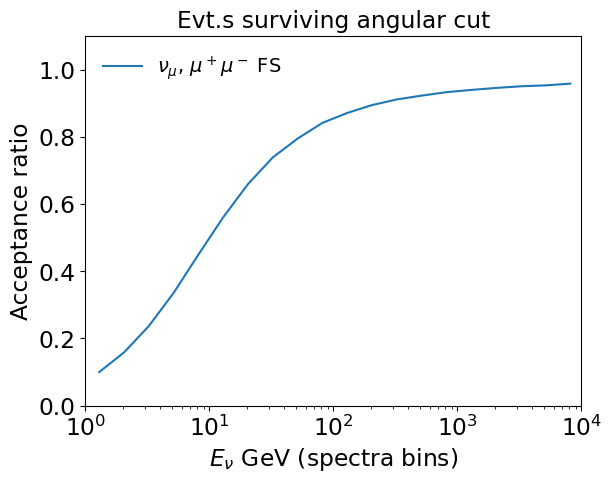

In [59]:
def angularCutSurvivalRatio(proc,detector,genpair):

    #Fetch bins
    genpairstr = '&'.join(list(genpair.values()))
    baseline1 = model(detector=detector,radN='_rad1',lambdamat=genPairLambdaMatrix(genpair))    
    ebins = np.array(baseline1['14']['ebins'])
    ecenters = (ebins[1:]+ebins[:-1])/2
    plt.clf()
    
    #Check numu, antinumu, nue, antinue separately
    lstyles = {'12': 'dashed', '-12': 'dashdotted', '14': 'solid', '-14' : 'dotted'}
    vpidtags = {'12' : r'$\nu_e$, $\mu^+\mu^-$ FS',\
                '-12': r'$\nu_{\overline{e}}$, $\mu^+\mu^-$ FS',\
                '14' : r'$\nu_\mu$, $\mu^+\mu^-$ FS',\
                '-14': r'$\nu_{\overline{\mu}}$, $\mu^+\mu^-$ FS',\
                '16' : r'$\nu_\tau$, $\mu^+\mu^-$ FS',\
                '-16': r'$\nu_{\overline{\tau}}$, $\mu^+\mu^-$ FS'}

    #The behavior is identical for all initial vpids, hence we only show nu_mu here
    for vpid in ['14']: #vpidstrs:
        cuts = findCuts(detector=detector,pred=genpairstr,proc=proc,vpidstr=vpid,\
                        dMax=-1,angleMax=thetaMax,Ebins=ecenters)
        #Plot acceptance ratio
        plotTest(plt.plot(ecenters, cuts, label=vpidtags[vpid]),\
                 testsubdir = 'dimuons-tridents',\
                 testtag = codename+'_angularCutSurvivalRatio_'+proc+'_'+vpid,\
                 mode = 'plot')
        #Printout histos convoluted w/ spectra
        entries = np.array(baseline1[vpid]['n_int_'+proc]).T[0]
        print('nu ID = '+vpid+', entries:')
        print(entries)
        print('Total number of events before cuts for '+genpairstr+': '+str(sum(entries)))
        print('Total number of events after cuts for '+genpairstr+': '+str(sum(np.multiply(cuts,entries))))
    
    #Plot style setup
    plt.title('Evt.s surviving angular cut')
    plt.xlabel(r'$E_\nu$ GeV (spectra bins)')
    plt.ylabel(r'Acceptance ratio')
    plt.xscale('log')
    plt.xlim(1,1e4)
    plt.ylim(0,1.1)
    plt.legend(frameon=False)
    savename = 'plots/'+proc+'_cut_survival_ratio.pdf'
    print('Saving image '+savename)
    plt.savefig(savename)
    plt.show()

#Doesn't really matter which detector is used, look only at trident mc statistics
angularCutSurvivalRatio(proc='tridents',detector=detectors[0],genpair=genpairBL)

### Single-pion background

Besides DIS dimuon production, there are also backgrounds from single pions decaying into muons. Here we illustrate the effect of the proposed cuts against such events, using externally-produced single-pion background histos.

In [3]:
def singlepiTableReader(filename,ebins,Ecol=0,Ncol=1):
    f = open(filename, "r")
    E,N=[],[]
    lines=[]
    lines=f.readlines()
    lines.pop(0)  #Remove header
    for l in lines:
        lsplit = l.split()
        E.append(float(lsplit[Ecol]))
        N.append(float(lsplit[Ncol]))
    f.close()
    N_rebin,E_rebin,_ = plt.hist(E,weights=N,histtype='step',bins=ebins,lw=0)
    return E_rebin,N_rebin

Saved plots/single_pi_bg.pdf


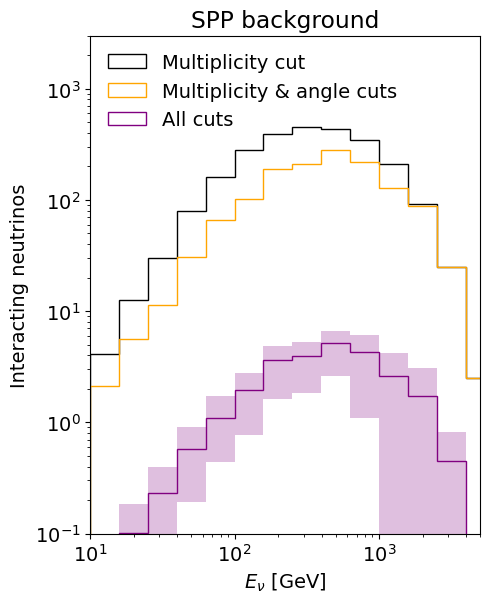

<Figure size 640x480 with 0 Axes>

In [4]:
def singlePiPlot():
    plt.rcParams.update({'font.size': 14})
    plt.rcParams['legend.loc'] = 'upper left'
    
    fig = plt.figure(figsize=(5,6))
    ax11 = fig.add_axes([0.20, 0.12, 0.78, 0.83], )
    axes = np.array([[ax11]])

    #Tables from ST
    files={}
    files[r'Multiplicity cut']          = ['single_pion_multiplicity',           'black' ]
    files[r'Multiplicity & angle cuts'] = ['single_pion_multiplicity_AND_angle', 'orange']
    files[r'All cuts']                  = ['single_pion_finalcuts',              'purple']
    
    bins=np.logspace(0,4,21)  #TODO fetch bins from model
    
    #Fetch central histos
    singlepidir='files/singlepi/'
    for key in list(files.keys()):
        E,N=singlepiTableReader(singlepidir+files[key][0]+'.txt',ebins=bins)
        axes[0,0].hist([0.5*(E[i]+E[i+1]) for i in range(len(E)-1)],\
                       weights=N,histtype='step',bins=E,color=files[key][1],label=key) 

    #Uncertainty for the final cuts case
    _,Nlo = singlepiTableReader(singlepidir+files[r'All cuts'][0]+'.txt',ebins=bins,Ncol=3)
    _,Nup = singlepiTableReader(singlepidir+files[r'All cuts'][0]+'.txt',ebins=bins,Ncol=2)
    axes[0,0].bar(x=bins[:-1],\
                  height=np.add(Nup,np.multiply(-1,Nlo)),\
                  bottom=Nlo,\
                  width=np.diff(bins),\
                  align='edge', linewidth=0, color=files[r'All cuts'][1],\
                  alpha=0.25, zorder=-1)

    #Plotstyle setup
    axes[0,0].set_title(r'SPP background')
    axes[0,0].set_ylabel(r'Interacting neutrinos')
    axes[0,0].set_xlabel(r'$E_\nu$ [GeV]')
    axes[0,0].set_xscale('log')
    axes[0,0].set_yscale('log')
    axes[0,0].set_xlim(10,5000)
    axes[0,0].set_ylim(1e-1,3000)
    axes[0,0].legend(frameon=False)

    filename = 'plots/single_pi_bg.pdf'
    print('Saved '+filename)
    plt.savefig(filename)
    plt.show()
    plt.clf()
    
singlePiPlot()

### Plot SM trident events vs all bg events

In [62]:
#Ratios of baseline entries surviving cuts. NB these need to be global
cutWgtDimuons       = findCuts(detector=detectors[0],pred=genpairBLstr,proc='dimuons', vpidstr='14',Donly=False,dMax=LdecMax,angleMax=thetaMax,NchCut=NchMax,Ebins=ecenters)
cutWgtDimuons_Donly = findCuts(detector=detectors[0],pred=genpairBLstr,proc='dimuons', vpidstr='14',Donly=True, dMax=LdecMax,angleMax=thetaMax,NchCut=NchMax,Ebins=ecenters)
cutWgtTridents      = findCuts(detector=detectors[0],pred=genpairBLstr,proc='tridents',vpidstr='14',            dMax=LdecMax,angleMax=thetaMax,NchCut=-1,    Ebins=ecenters)

Dimuon file empty at iE = 1
Dimuon file empty at iE = 2
Dimuon file empty at iE = 3
Dimuon file empty at iE = 4
Dimuon file empty at iE = 6
Read MC bins for FASERv2, EPOSLHC&BKRS
Read MC bins for FASERv2, EPOSLHC&BKRS


For nu id 14
  Total #neutrinos =  20380567955415.11
  Total #[dimuon bg int.act.]  =  3988.5190556483967
  #[bg int.act.]  surviving cuts =  0.3518272862198497
  #[-||-, D-only] surviving cuts =  0.00010254778883812917
  Total #[signal int.act.]  =  11.910590771139505
  #[signal int.act.] surviving cuts =  11.044287214106603
  Survival percentage: 0.9272661135220901
Saved  plots/cSBBB_lSQEE_acc_dimuons_vs_tridents_1_radial_bin_FASERv2.pdf


<Figure size 640x480 with 0 Axes>

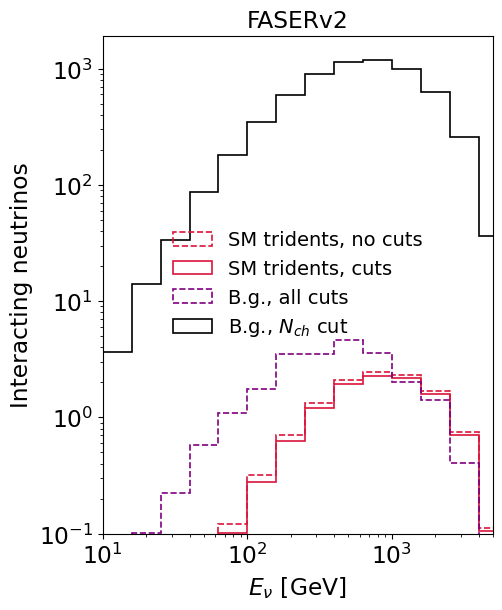

In [63]:
def allBgPlot():
    
    detector='FASERv2'  #Due to using external single pion bg tables for FASERv2, cannot generalize detector    
    filename='plots/'+codename+'_dimuons_vs_tridents_1_radial_bin_'+detector+'.pdf'

    #Dimuons as baseline, compare to tridents
    baseline1 = model(detector=detector,radN='_rad1',lambdamat=genPairLambdaMatrix(genpairBL))    
    ebins = np.array(baseline1[vpidstrs[0]]['ebins'])
    ecenters = (ebins[1:]+ebins[:-1])/2
    base_entries1 = {}
    nmax = 1
    #Extract information from baseline
    entries1 = np.array(baseline1['14']['n_int_dimuons']).T[0]
    base_entries1['14'] = entries1
    trident_entries1 = np.array(baseline1['14']['n_int_tridents']).T[0]
    if max(entries1)>nmax: nmax=max(entries1)

    #Fetch single pion histos
    EpiCuts,NpiCuts = singlepiTableReader('files/singlepi/single_pion_finalcuts.txt',   ebins=ebins)
    EpiNch, NpiNch  = singlepiTableReader('files/singlepi/single_pion_multiplicity.txt',ebins=ebins)
    plt.clf()
    
    #Setup figure
    matplotlib.rcParams.update({'font.size': 14})
    matplotlib.rcParams.update({'legend.fontsize': 'medium'})
    matplotlib.rcParams.update({'axes.labelsize': 'large'})
    matplotlib.rcParams.update({'axes.titlesize':'large'})
    matplotlib.rcParams.update({'xtick.labelsize':'large'})
    matplotlib.rcParams.update({'ytick.labelsize':'large'})
    matplotlib.rcParams['text.usetex'] = False
    fig = plt.figure(figsize=(5,6))
    ax11 = fig.add_axes([0.20, 0.12, 0.78, 0.83], )
    axes = np.array([[ax11]])
     
    #Trident events
    axes[0,0].hist(x=ecenters, weights=trident_entries1, bins=ebins,\
                   histtype='step', color='crimson', ls='dashed', lw=1.2,label='SM tridents, no cuts')
    axes[0,0].hist(x=ecenters, weights=np.multiply(trident_entries1,cutWgtTridents), bins=ebins,\
                   histtype='step', color='crimson', ls='solid', lw=1.2,label='SM tridents, cuts')

    #SM b.g. events surviving all cuts
    axes[0,0].hist(x=ecenters, weights=np.add(np.multiply(cutWgtDimuons,entries1),NpiCuts), bins=ebins,\
                   histtype='step', color='purple', ls='dashed', lw=1.2,label='B.g., all cuts')
    
    #All SM b.g. events
    axes[0,0].hist(x=ecenters, weights=np.add(entries1,NpiNch), bins=ebins,\
                   histtype='step', color='black', ls='solid', lw=1.2,label=r'B.g., $N_{ch}$ cut')
    
    #Check number of events
    nnus  = baseline1['14']['n_nu'].flatten()
    nints = baseline1['14']['n_int_dimuons'].flatten()
    print('For nu id 14')
    print('  Total #neutrinos = ',sum(nnus))    
    print('  Total #[dimuon bg int.act.]  = ',sum(nints))    
    print('  #[bg int.act.]  surviving cuts = ',sum(np.multiply(cutWgtDimuons,nints)))    
    print('  #[-||-, D-only] surviving cuts = ',sum(np.multiply(cutWgtDimuons_Donly,nints)))    
    nints = np.array(baseline1['14']['n_int_tridents']).T[0]
    print('  Total #[signal int.act.]  = ',sum(nints))
    print('  #[signal int.act.] surviving cuts = ',sum(np.multiply(cutWgtTridents,nints)))
    print('  Survival percentage:',sum(np.multiply(cutWgtTridents,nints))/sum(nints))
        
    #Plotstyle setup
    axes[0,0].set_xlabel(r'$E_\nu$ [GeV]')
    axes[0,0].set_ylabel("Interacting neutrinos")
    axes[0,0].set_xscale("log")
    axes[0,0].set_yscale("log")
    axes[0,0].set_xlim(10,5000)
    axes[0,0].set_ylim(1e-1,nmax*2.3)
    axes[0,0].set_title(detector)
    matplotlib.rcParams.update({'legend.loc':'center'})
    axes[0,0].legend(frameon=False)
    
    #finalize figure
    if filename is not None: 
        plt.savefig(filename)
        print('Saved ',filename)
    plt.show()

if useAcc:
    allBgPlot()

## Fetch spectrum histograms

In [64]:
def printSpectraHistos(detector,procs,vpidstr,genpair):    
    for proc in procs:
        modelResult = model(detector=detector,radN='_rad1',lambdamat=genPairLambdaMatrix(genpair))
        nnus  = modelResult[vpidstr]['n_nu'].flatten()
        nints = modelResult[vpidstr]['n_int_'+proc].flatten()
        ebins = np.array(modelResult[vpidstr]['ebins'])
        ecenters = (ebins[1:]+ebins[:-1])/2
    
        print('\n'+detector+' incoming muon neutrinos ('+proc+'):')
        for ec,nnu in zip(ecenters,nnus): print(str(ec)+'  '+str(nnu))
        
        print('\n'+detector+' interacting muon neutrinos ('+proc+') tot. '+str(sum(nints)))
        for ec,nint in zip(ecenters,nints): print(str(ec)+'  '+str(nint))
        
        if proc=='dimuons':            
            print('\n'+detector+' interacting muon neutrinos ('+proc+') surviving cuts:')
            for ec,nint in zip(ecenters,np.multiply(cutWgtDimuons,nints)): print(str(ec)+'  '+str(nint))
            print('\n'+detector+' interacting muon neutrinos ('+proc+') surviving cuts (D only):')
            for ec,nint in zip(ecenters,np.multiply(cutWgtDimuons_Donly,nints)): print(str(ec)+'  '+str(nint))    
        
        elif proc=='tridents':
            print('\n'+detector+' interacting muon neutrinos ('+proc+') surviving cuts: tot. '+\
                  str(sum(np.multiply(cutWgtTridents,nints))))
            for ec,nint in zip(ecenters,np.multiply(cutWgtTridents,nints)): print(str(ec)+'  '+str(nint))

printSpectraHistos(detector=detectors[0],procs=['dimuons','tridents'],vpidstr='14',genpair=genpairBL)



FASERv2 incoming muon neutrinos (dimuons):
1.292446596230557  0.0
2.0483898119853468  0.0
3.2464790685222766  0.0
5.1453225751684535  0.0
8.154786722400967  0.0
12.924465962305572  191937150068.52786
20.483898119853475  362962042358.8308
32.46479068522277  698969266703.707
51.45322575168453  1232471621508.0222
81.54786722400966  1993078338892.8394
129.24465962305572  2720288084150.4907
204.83898119853484  3246088545653.6963
324.6479068522278  3363131567971.8726
514.5322575168454  2940099855424.967
815.4786722400968  1968178143195.8745
1292.4465962305571  1077387977591.4927
2048.389811985348  456204449591.50305
3246.479068522278  118872476631.80896
5145.322575168455  10879711013.866022
8154.786722400968  18724657.60763251

FASERv2 interacting muon neutrinos (dimuons) tot. 3988.5190556483967
1.292446596230557  0.0
2.0483898119853468  0.0
3.2464790685222766  0.0
5.1453225751684535  0.0
8.154786722400967  0.0
12.924465962305572  0.07229688788497159
20.483898119853475  0.4334553691808852
3

In [65]:
def plotTridentSpectra(fs=0.0):

    #Here we will compare the global generator baseline to a set of other predictions.
    #Thus N.B. genpair, genpairBL need to be separate variables!
    global genpairBL
    global genpairBLstr
    
    tridentprocs=[]
    if 'tridents' in allprocs: tridentprocs+=['tridents']
    if non_mumu_FS: tridentprocs+=['tridents_ee','tridents_emu','tridents_etau','tridents_mutau','tridents_tautau']
    
    for proc in tridentprocs:
        for detector in detectors:
        
            fsstr=''
            if fs>0.0: fsstr = '_fs' + str(fs).replace('.','')
            filename = 'plots/' + codename + '_' + proc + '_1_radial_bin_' + detector + fsstr + '.pdf'
            
            #Setup figure
            matplotlib.rcParams.update({'font.size': 14})
            matplotlib.rcParams.update({'legend.fontsize': 'medium'})
            matplotlib.rcParams.update({'axes.labelsize': 'large'})
            matplotlib.rcParams.update({'axes.titlesize':'large'})
            matplotlib.rcParams.update({'xtick.labelsize':'large'})
            matplotlib.rcParams.update({'ytick.labelsize':'large'})
            matplotlib.rcParams['text.usetex'] = False
            fig = plt.figure(figsize=(8,6))
            ax11 = fig.add_axes([0.18, 0.15, 0.41, 0.70], )
            ax21 = fig.add_axes([0.59, 0.15, 0.41, 0.70], yticklabels=[], )
            axes = np.array([[ax11],[ax21]])
            
            #Left panel: nu_mu+nubar_mu+nu_e+nubar_e per prediction & associated charm predictions
            #Plot select prediction pairings: lambdagens[i] contains lambdamatrices of interesting prediction pairs
            lambdagens=[genPairLambdaMatrix({'light':genpair[0], 'charm':genpair[1]}) for genpair in gens]    
            #Store the "model" objects corresponding to above generator-specific lambdamatrices
            genmodels=[]
            for lgenspec in lambdagens:
                genmodels.append(model(detector=detector,radN='_rad1',lambdamat=lgenspec,modelpars={'fs':fs}))
        
            #Print energy bins as a reminder
            print(ebins)
                    
            #Fetch model result projection for this rbin, store different nu flavor contributions to "entries"
            entries={}
            colors=['dodgerblue','green','orange','maroon']
            nmax = 1  #tmp init
            for igm,genmodel in enumerate(genmodels):
                entries[igm]=[]
                for ivpid,vpid in enumerate(vpidstrs):
                    entries[igm].append(np.array(genmodel[vpid]['n_int_'+proc]).T[0])
                h = axes[0,0].hist(x=ecenters, weights=sum(entries[igm]), bins=ebins,\
                                   histtype='step', color=colors[igm], ls='solid', lw=1.2)
                genpairstr='&'.join(gens[igm])
                ##Write histogram heights to file
                #f = open('./trident_histo_output/'+proc+'_'+detector+'_'+genpairstr+fsstr+'.txt', "w")
                #f.write(detector+', fs='+str(fs)+': '+proc+' #events (all nu flavors) for '+\
                #        genpairstr+', tot: '+str(sum(sum(entries[igm]))))
                #f.write('\n')
                #for i,number in enumerate(sum(entries[igm])):
                #    f.write(str(ecenters[i])+'    '+str(number))
                #    f.write('\n')
                #f.close()                            
                axes[0,0].plot(-1,1, color=colors[igm], ls='solid', lw=1.2,label=' & '.join(gens[igm]))        
        
            #Right panel, show separate flavor's contributions for a single generator combination
            baseline = model(detector=detector,radN='_rad1',lambdamat=genPairLambdaMatrix(genpairBL),\
                              modelpars={'fs':fs})    
            trident_entries = {}
            nmax = 1
            #Extract information for axes
            vpidlabels = { "12": r"$\nu_e$",        "14": r"$\nu_\mu$",        "16": r"$\nu_\tau$",\
                          "-12": r"$\bar{\nu}_e$", "-14": r"$\bar{\nu}_\mu$", "-16": r"$\bar{\nu}_\tau$"}
            colors={}
            colors[12]='red'
            colors[14]='black'
            colors[16]='blue'
            for vpid in vpidstrs:
                trident_entries[vpid] = np.array(baseline[vpid]['n_int_'+proc]).T[0]
                if max(trident_entries[vpid])>nmax: nmax=max(entries)
                lstyle = 'dashed' if '-' in vpid else 'solid'
                #Trident events
                axes[1,0].hist(x=ecenters, weights=trident_entries[vpid], bins=ebins,\
                               histtype='step', color=colors[abs(int(vpid))], ls=lstyle, lw=1.2)
                print('Total number of events ('+genpairBLstr+') for vpid='+str(vpid)+': '+str(sum(trident_entries[vpid])))
                axes[1,0].plot(-1,1, color=colors[abs(int(vpid))], ls=lstyle, lw=1.2,label=vpidlabels[vpid])        
            
                
            #Plotstyle setup
            axes[0,0].set_ylabel("Trident interactions")
            for i in range(len(axes)):
                axes[i,0].set_xlabel(r'$E_\nu$ [GeV]')
                axes[i,0].set_xscale("log")
                axes[i,0].set_yscale("log")
                axes[i,0].set_xlim(10,5000)
                axes[i,0].set_ylim(1e-2,100)
            axes[1,0].set_yticklabels([])
            titlestr = detector.replace('FASERv',r'FASER$\nu$') + r': di-muon tridents'
            #titlestr = detector + r': ' + '+'.join([vpidlabels[vpid] for vpid in vpidstrs])
            axes[0,0].set_title(titlestr)
            axes[1,0].set_title(genpairBLstr.replace('&',' & '))
            matplotlib.rcParams.update({'legend.loc':'upper left'})
            axes[0,0].legend(frameon=False)
            axes[1,0].legend(frameon=False)
            
            #finalize figure
            if filename is not None: 
                plt.savefig(filename)
                print('Saved ',filename)
            plt.show()

In [66]:
#Plot only if experimental efficiencies not considered.
#The plot is given early on in the paper, and including acceptances at that stage only obfuscates the introduction
if not useAcc:
    plotTridentSpectra()

### Same as above, but $f_s=0.5$

In [67]:
if not useAcc:
    plotTridentSpectra(fs=0.5)

### D meson decay length distributions
$d = \gamma\beta c\tau$, where $\gamma = E/m$ is the Lorentz factor, $\beta = v/c \sim 1$, 
and $\tau$ is the meson's lifetime.
N.B. we account for the (small) difference in lifetime between neutral and charged $D$ mesons (2nd muon parent)
     since they appear differently in emulsion

In [68]:
def plotDecayLengthsAnd2ndMuonParents(detector,genpair):
    
    #Init
    Dch_d=[]
    D0_d=[]
    Dch_w=[]
    Dch_Nchcut=[]
    D0_w=[]
    D0_Nchcut=[]
    E_m2={}
    E_m2_w={}
    E_m2_Nchcut={}
    
    global mcbins
    genpairstr = '&'.join(list(genpair.values()))
    fetchmcbins(genpairstr=genpairstr,detector=detector,inprocs=['dimuons'])
    for iE in range(1,len(Evals)+1):
        tmp = mcbins['dimuons']['14'][str(iE)]
        for i in range(len(tmp['x'])):
            #Ensure 2nd muon w/ momentum > 0 exists
            if tmp['E_2' ][i]==0 and tmp['px_2'][i]==0 and tmp['py_2'][i]==0 and tmp['pz_2'][i]==0:
                continue        
            name2m = tmp['name_2m'][i]  #Abbreviation for the name of 2nd muon parent hadron
            if name2m in Dmesons:
                d = decayLength(name=name2m,px=tmp['px_2m'][i],py=tmp['py_2m'][i],pz=tmp['pz_2m'][i])
                if d<0.:
                    print('WARNING: cannot compute decay length, skipping')
                    continue
                if name2m in Dch:
                    Dch_d.append(d)
                    Dch_w.append(tmp['spectrawgt'][i])
                    Dch_Nchcut.append(tmp['Nch'][i]<=NchMax)
                elif name2m in Dnt:  
                    D0_d.append(d)
                    D0_w.append(tmp['spectrawgt'][i])
                    D0_Nchcut.append(tmp['Nch'][i]<=NchMax)
            if name2m not in list(E_m2.keys()): 
                E_m2[name2m]=[] 
                E_m2_w[name2m]=[] 
                E_m2_Nchcut[name2m]=[]
            E_m2[name2m].append(tmp['E_2m'][i])
            E_m2_w[name2m].append(tmp['spectrawgt'][i])
            E_m2_Nchcut[name2m].append(tmp['Nch'][i]<=NchMax)
    
    #Plot decay length histo(s) with linear vertical axis, zoomed in
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_axes([0.16, 0.12, 0.82, 0.82])
    bins_Dch_d  = np.linspace(0,2e-2,30)
    h_Dch = plt.hist(np.multiply(1000,Dch_d), bins=np.multiply(1000,bins_Dch_d),\
                     weights=Dch_w,color='gray', label=r', '.join(DchLtX))
    h_D0  = plt.hist(np.multiply(1000,D0_d),  bins=np.multiply(1000,bins_Dch_d),\
                     weights=D0_w,color='maroon', alpha=0.5,label=r', '.join(DntLtX))
    plotTest(h_Dch, testsubdir = 'dimuons-tridents',\
             testtag = codename+'_DecayLengthsAnd2ndMuonParents_Dch_'+detector+'_'+genpairstr,\
             mode = 'histo')
    plotTest(h_D0, testsubdir = 'dimuons-tridents',\
             testtag = codename+'_DecayLengthsAnd2ndMuonParents_D0_'+detector+'_'+genpairstr,\
             mode = 'histo')

    plt.plot([1000*LdecMax,1000*LdecMax],[0,120],color='black',linestyle='dashed')
    plt.title(r'Convoluted with '+genpairstr+r' spectrum')
    plt.xlabel(r'Decay length [mm]')
    plt.ylabel(r'$N$')
    plt.ylim(0,110)
    matplotlib.rcParams.update({'legend.fontsize': 'small'})
    matplotlib.rcParams.update({'legend.loc':'upper right'})
    matplotlib.rcParams.update({'legend.frameon':False})
    plt.legend()
    savename='plots/D_decay_lengths_linear_zoom.pdf'
    print('Saving image '+savename)
    plt.savefig(savename)
    plt.show()
    plt.clf()
    
    #Decay length histo after multiplicity cut
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_axes([0.16, 0.12, 0.82, 0.82])
    bins_Dch_d  = np.linspace(0,2e-2,30)
    h_Dch = plt.hist(np.multiply(1000,Dch_d), bins=np.multiply(1000,bins_Dch_d),\
                     weights=np.multiply(Dch_w,Dch_Nchcut),\
                     color='gray', label=r', '.join(DchLtX))
    h_D0  = plt.hist(np.multiply(1000,D0_d),  bins=np.multiply(1000,bins_Dch_d),\
                     weights=np.multiply(D0_w, D0_Nchcut ),\
                     color='maroon', alpha=0.5,label=r', '.join(DntLtX))
    plotTest(h_Dch, testsubdir = 'dimuons-tridents',\
             testtag = codename+'_DecayLengthsAnd2ndMuonParents_Dch_Nchcut_'+detector+'_'+genpairstr,\
             mode = 'histo')
    plotTest(h_D0, testsubdir = 'dimuons-tridents',\
             testtag = codename+'_DecayLengthsAnd2ndMuonParents_D0_Nchcut_'+detector+'_'+genpairstr,\
             mode = 'histo')    
    plt.plot([1000*LdecMax,1000*LdecMax],[0,10],color='black',linestyle='dashed')
    plt.title(r'Conv. w/ '+genpairstr+r', $N_{ch}$ cut')
    plt.xlabel(r'Decay length [mm]')
    plt.ylabel(r'$N$')
    plt.ylim(0,1)
    matplotlib.rcParams.update({'legend.fontsize': 'small'})
    matplotlib.rcParams.update({'legend.loc':'upper right'})
    matplotlib.rcParams.update({'legend.frameon':False})
    plt.legend()
    savename='plots/D_decay_lengths_linear_zoom_Nchcut.pdf'
    print('Saving image '+savename)
    plt.savefig(savename)
    plt.show()
    plt.clf()
    
    #Plot parent hadron energy histos
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_axes([0.16, 0.12, 0.90, 0.92])
    if len(list(E_m2.keys())) > len(list(hadronstyles.keys())):
        print('ERROR: you need to specify '+str(len(list(E_m2.keys()))-len(list(hadronstyles.keys())))+' more colors')
    binsEhad = np.linspace(0,studyE,50)
    #Plot normalized histos
    plt.clf()
    for m2name in list(E_m2.keys()):
        h = plt.hist(E_m2[m2name],bins=binsEhad,weights=E_m2_w[m2name],\
                     color=hadronstyles[m2name][1],label=hadronstyles[m2name][0],histtype='step')
        plotTest(h, testsubdir = 'dimuons-tridents',\
                 testtag = codename+'_E_2nd_muon_parents_'+detector+'_'+genpairstr,\
                 mode = 'histo')        
    plt.title(r'Convoluted with '+genpairstr+r' spectrum')
    plt.xlabel(r'2nd $\mu$ parent energy [GeV]')
    plt.ylabel(r'$N$')
    plt.yscale('log')
    plt.ylim(1e0,1e3)
    plt.xlim(0,1000)
    matplotlib.rcParams.update({'legend.fontsize': 'x-small'})
    plt.legend(ncol=5,frameon=False)
    savename='plots/E_2nd_muon_parents.pdf'
    print('Saving image '+savename)
    plt.savefig(savename)
    plt.show()
    plt.clf()
    
    #Parent hadron energy histos with charged track multiplicity cut
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_axes([0.16, 0.12, 0.90, 0.92])
    if len(list(E_m2.keys())) > len(list(hadronstyles.keys())):
        print('ERROR: you need to specify '+str(len(list(E_m2.keys()))-len(list(hadronstyles.keys())))+' more colors')
    binsEhad = np.linspace(0,studyE,50)
    #Plot normalized histos
    plt.clf()
    for m2name in list(E_m2.keys()):
        h = plt.hist(E_m2[m2name],bins=binsEhad, weights=np.multiply(E_m2_w[m2name],E_m2_Nchcut[m2name]),\
                     color=hadronstyles[m2name][1],label=hadronstyles[m2name][0],histtype='step')
        plotTest(h, testsubdir = 'dimuons-tridents',\
                 testtag = codename+'_E_2nd_muon_parents_Nchcut_'+detector+'_'+genpairstr,\
                 mode = 'histo')        
    plt.title(r'Convoluted with '+genpairstr+r' spectrum')
    plt.xlabel(r'2nd $\mu$ parent energy [GeV]')
    plt.ylabel(r'$N$')
    plt.yscale('log')
    plt.ylim(1e0,1e3)
    plt.xlim(0,1000)
    matplotlib.rcParams.update({'legend.fontsize': 'x-small'})
    plt.legend(ncol=5,frameon=False)
    savename='plots/E_2nd_muon_parents_Nchcut.pdf'
    print('Saving image '+savename)
    plt.savefig(savename)
    plt.show()
    plt.clf()

#Plot only if experimental efficiencies not considered (plot given early on in the paper, 
#including acceptances at that stage would only obfuscate the introduction)
if not useAcc:
    plotDecayLengthsAnd2ndMuonParents(detector=detectors[0],genpair=genpairBL)

## 4-Fermi studies

In [69]:
#Param:
#  detectorlist  List of detectors to consider for a combined measurement
#  radNstr       E.g. '_rad1'
#  genpair       The generator pair to assume as the baseline prediction
#  CL            Confidence level, e.g. 0.95 for 95%
#  fstatlist     List of fstat values for the detectors
#  spcase        Use '_low'/'_up' to compute the best/worst-case single pion bg, use central/mean if '' 
#Returns a list [#events required to distinguish from SM if less events than SM, -||- more than SM]
#        and a matrix of event numbers corresponding to combinations of dGV and dGA
def find4Fconstraints_nints(detectorlist,radNstr,genpair,CL,fstatlist,spcase=''):
    
    global dGVvals
    global dGAvals
    
    #SM baseline model and total number of interactions
    baseline = detectorSum(detectorlist=detectorlist,\
                           radNstr=radNstr,\
                           genpair=genpair,\
                           fstatlist=fstatlist,\
                           modelpars={})        
    SM_nints = sum(sum([baseline[vpid]['n_int_tridents'].flatten() for vpid in list(baseline.keys())]))
    
    #Add single pion background. Other bg reduced negligible by the introduced cuts
    ebins = baseline[vpidstrs[0]]['ebins']
    Ncol=1
    if 'up' in spcase: Ncol=2
    elif 'low' in spcase: Ncol=3
    E,Nbg=singlepiTableReader('files/singlepi/single_pion_finalcuts.txt',ebins=ebins,Ncol=Ncol)
    plt.clf()
    Nbgsum = sum(Nbg)
    SM_nints += Nbgsum
    
    #Find constraint for BSM>SM case via the number of excess events required to be distinct from SM
    constraints=[findPoissonConstraint(detectorlist=detectorlist,SM_nints=SM_nints,CL=CL,dmu_i=-1.0),\
                 findPoissonConstraint(detectorlist=detectorlist,SM_nints=SM_nints,CL=CL,dmu_i=1.0)]
    
    #Loop through dGV,dGA grid to find thenumber of events
    ret={}
    nints=[]
    for i,dGVstr in enumerate(dGVvals):
        dGV = float(dGVstr)
        nints_dGV=[]
        for dGAstr in dGAvals:
            dGA = float(dGAstr)
            varied = detectorSum(detectorlist=detectorlist,\
                                 radNstr=radNstr,\
                                 genpair=genpair,\
                                 fstatlist=fstatlist,\
                                 modelpars={'dGV':dGV,'dGA':dGA})
            variedsum = sum(sum([varied[vpid]['n_int_4F'].flatten() for vpid in list(baseline.keys())]))
            nints_dGV.append(variedsum+Nbgsum)  #Add single-pion bg to varied trident signal
        print('Computed '+str(100*(i+1)/len(dGVvals))+'% of event count grid for '\
              +'&'.join(detectorlist) + ', w/ fstats '\
              +'&'.join([str(fstat) for fstat in fstatlist]))
        nints.append(np.array(nints_dGV))
    nints = np.array(nints)
    nints = np.reshape(nints, (len(dGVvals), len(dGAvals)))
    return constraints, nints


In [70]:
n_int_4f={}
constr_4f={}
if FourFermi:
    tag='FASERv2_50%'
    constr_4f[tag], n_int_4f[tag] = find4Fconstraints_nints(detectorlist=['FASERv2'],\
                                                            radNstr='_rad1',\
                                                            genpair=genpairBL,\
                                                            CL=0.95,\
                                                            fstatlist=[0.5])
    tag='FASERv2'
    constr_4f[tag], n_int_4f[tag] = find4Fconstraints_nints(detectorlist=['FASERv2'],\
                                                            radNstr='_rad1',\
                                                            genpair=genpairBL,\
                                                            CL=0.95,\
                                                            fstatlist=[1.0])
    tag='FASERv2_up'
    constr_4f[tag], n_int_4f[tag] = find4Fconstraints_nints(detectorlist=['FASERv2'],\
                                                            radNstr='_rad1',\
                                                            genpair=genpairBL,\
                                                            CL=0.95,\
                                                            fstatlist=[1.0],\
                                                            spcase='_up')
    tag='FASERv2_low'
    constr_4f[tag], n_int_4f[tag] = find4Fconstraints_nints(detectorlist=['FASERv2'],\
                                                            radNstr='_rad1',\
                                                            genpair=genpairBL,\
                                                            CL=0.95,\
                                                            fstatlist=[1.0],\
                                                            spcase='_low')    

FASERv2 SM expected n.o. events=33, dmu=-0.0010000000000000002, constraint=24.151999999999973, final P = 0.9500152578895336
FASERv2 SM expected n.o. events=33, dmu=0.0010000000000000002, constraint=42.98299999999999, final P = 0.9500082316864898
Computed 4.0% of event count grid for FASERv2, w/ fstats 0.5
Computed 8.0% of event count grid for FASERv2, w/ fstats 0.5
Computed 12.0% of event count grid for FASERv2, w/ fstats 0.5
Computed 16.0% of event count grid for FASERv2, w/ fstats 0.5
Computed 20.0% of event count grid for FASERv2, w/ fstats 0.5
Computed 24.0% of event count grid for FASERv2, w/ fstats 0.5
Computed 28.0% of event count grid for FASERv2, w/ fstats 0.5
Computed 32.0% of event count grid for FASERv2, w/ fstats 0.5
Computed 36.0% of event count grid for FASERv2, w/ fstats 0.5
Computed 40.0% of event count grid for FASERv2, w/ fstats 0.5
Computed 44.0% of event count grid for FASERv2, w/ fstats 0.5
Computed 48.0% of event count grid for FASERv2, w/ fstats 0.5
Computed 52.

<Figure size 640x480 with 0 Axes>

In [71]:
#Plot contours based on the constraints on the number of events
#Param  matrixdict   Matrices containing the event counts corresponding to a combination of row&col variables,
#                    one matrix per experiment (combination) & fstat -pair.
#       rows         A vector containing the values to which the matrix rows correspond to 
#       cols                                  -||-                      columns   -||- 
#       contourdict  Numbers corresponding to which to plot the contours, e.g. [SM-delta, SM+delta] for each tag
def contourplot(matrixdict,rows,cols,contourdict,tags):
    
    #Init
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0.15, 0.13, 0.82, 0.80], )
    axes = np.array([[ax]])        
    approxInfty=10  #Large enough to always lies outside axis limits. No computational purpose here.
    alpha=0.3       #For enabling see-through fills
       
    #Ensure grid format and datatype based on input rows and cols (where values may be strings)
    rowg,colg = np.meshgrid([float(d) for d in rows],[float(d) for d in cols])
   
    #Plot contours
    maincolor='teal'
    #plt.imshow(BSM_nints, cmap='hot', interpolation='nearest')  #Heat map of the number of interactions 
    for i,key in enumerate(tags):
        lstyle='dotted' if '%' in key else 'solid'
        plt.contour(rowg,colg,matrixdict[key],\
                    levels=contourdict[key],\
                    colors=[maincolor for _ in contourdict[key]],
                    linestyles=[lstyle for _ in contourdict[key]])
        p = {}
        for uncaddon in ['_up','_low']:
            if key+uncaddon in list(matrixdict.keys()) and key+uncaddon in list(contourdict.keys()):
                p[uncaddon] = plt.contour(rowg,colg,matrixdict[key+uncaddon],\
                                          levels=contourdict[key+uncaddon],\
                                          colors=[maincolor for _ in contourdict[key+uncaddon]],
                                          linestyles=['solid' for _ in contourdict[key+uncaddon]])
        if '_up' in list(p.keys()) and '_low' in list(p.keys()):
            inner1 = p['_up' ].allsegs[0][0]
            inner2 = p['_low'].allsegs[0][0]
            plt.fill(np.append(inner1[:,0],inner2[::-1,0]),
                     np.append(inner1[:,1],inner2[::-1,1]),color=maincolor)
            outer1 = p['_up' ].allsegs[1][0]
            outer2 = p['_low'].allsegs[1][0]
            plt.fill(np.append(outer1[:,0],outer2[::-1,0]),
                     np.append(outer1[:,1],outer2[::-1,1]),color=maincolor)
        #For including FPF result in legend
        detectortag = key.replace('FASERv',r'FASER$\nu$')\
                         .replace('&',' & ')
        if '_' in detectortag: detectortag = detectortag.replace('_',' (') + ')'
        plt.plot([0],[0],color=maincolor,linestyle=lstyle,label=detectortag)
       
    #Indicate SM point via the intersection of two lines
    plt.plot([0.0,0.0],                  [-approxInfty,approxInfty], linestyle='solid', lw=0.5, color='black')
    plt.plot([-approxInfty,approxInfty], [0.0,0.0],                  linestyle='solid', lw=0.5, color='black')

    #CCFR and DUNE constraints for comparison
    #Plotstyle setup: experiment tag for filenames: [exp name, linestyle, fill color]
    comparisons={'DUNE_25': [r'DUNE (25% unc.)', 'dashed', 'sienna'],\
                 #'DUNE':    [r'DUNE',       'solid',  'midnightblue'],\
                 'CCFR':    [r'CCFR',       'solid',  'gainsboro']}
    for key in list(comparisons.keys()):
        dGVcomp = np.loadtxt('files/previous_constraints/tridents_FourFermi/'+key+'_outer.txt',usecols=0)
        dGAcomp = np.loadtxt('files/previous_constraints/tridents_FourFermi/'+key+'_outer.txt',usecols=1)
        plt.plot(dGVcomp,dGAcomp,\
                 linestyle=comparisons[key][1],\
                 label=comparisons[key][0],\
                 color=comparisons[key][2])
        if key=='CCFR':
            plt.fill(np.append(dGVcomp,[-approxInfty,-approxInfty,approxInfty,approxInfty,-approxInfty]),\
                     np.append(dGAcomp,[-approxInfty,approxInfty,approxInfty,-approxInfty,-approxInfty]),\
                     linewidth=0.,\
                     color=comparisons[key][2], alpha=alpha)
    for key in list(comparisons.keys()):
        dGVcomp = np.loadtxt('files/previous_constraints/tridents_FourFermi/'+key+'_inner.txt',usecols=0)
        dGAcomp = np.loadtxt('files/previous_constraints/tridents_FourFermi/'+key+'_inner.txt',usecols=1)
        plt.plot(dGVcomp,dGAcomp,linestyle=comparisons[key][1],color=comparisons[key][2])
        if key=='CCFR':
            plt.fill(dGVcomp,dGAcomp,color=comparisons[key][2],alpha=alpha)

    #Setup and save figure
    matplotlib.rcParams.update({'legend.loc':'upper left'})
    plt.legend(frameon=True)
    plt.title(r'$\nu_\mu N \to \nu_\mu \mu^+ \mu^- N$')
    plt.xlabel(r'$\Delta g_V$')
    plt.ylabel(r'$\Delta g_A$')
    plt.xlim(-5,1)
    plt.ylim(-2,4)
    filename = 'plots/'+codename+'_FFconstraint_'+('_'.join(tags)).replace('%','p')+'.pdf'
    if filename is not None: 
        plt.savefig(filename)
        print('Saved',filename)
    plt.show()
    plt.clf()    

Saved plots/cSBBB_lSQEE_acc_FFconstraint_FASERv2_FASERv2_50p.pdf


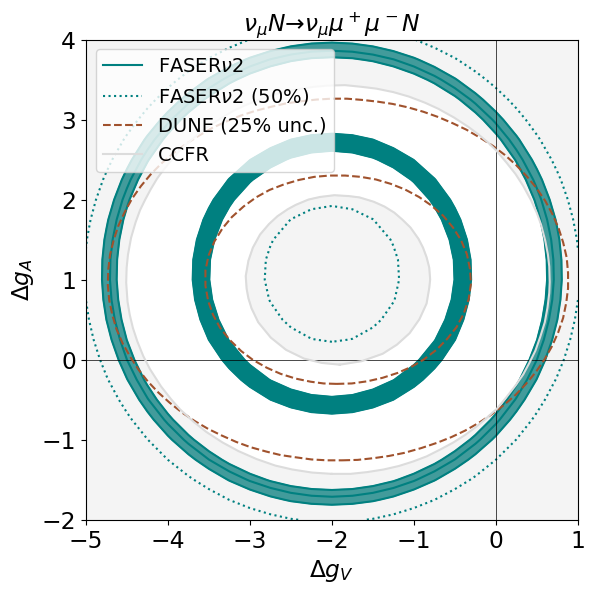

<Figure size 640x480 with 0 Axes>

In [72]:
if FourFermi:
    contourplot(matrixdict=n_int_4f,\
                rows=dGVvals,\
                cols=dGAvals,\
                contourdict=constr_4f,\
                tags=['FASERv2','FASERv2_50%'])